# Author: Suci Ramadhani Fauzi


---



# EDA in Python:


---


* Memahami pola penjualan (tren & seasonality)
* Mengidentifikasi kontributor utama revenue (kategori/produk)
* Melihat perilaku pelanggan (new & returning, RFM ringan)
* Mengevaluasi return rate secara deskriptif

# A. Setup & Dataset Overview

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns",None)

## Import Dataset

Notes: Dataset vw_sales_analytics yang sudah diexport csv dari Postgres

In [ ]:
df=pd.read_csv("/content/vw_sales_analytics_202512241538.csv", parse_dates=
               ["order_created_at",
               "item_created_at",
               "item_shipped_at",
               "item_delivered_at",
               "item_returned_at",
               "user_created_at"])

In [ ]:
df.shape

(181759, 38)

In [ ]:
df.head()

,order_item_id,order_id,user_id,product_id,inventory_item_id,order_created_at,item_created_at,item_shipped_at,item_delivered_at,item_returned_at,status,user_gender,user_age,user_city,user_state,user_country,user_traffic_source,user_created_at,product_name,product_brand,product_category,product_department,product_sku,product_cost,product_retail_price,distribution_center_id,distribution_center_name,dc_latitude,dc_longitude,quantity,unit_price,unit_cost,revenue,cogs,gross_margin,is_shipped,is_delivered,is_returned
0,154022,106052,84693,14235,415780,2023-09-15 12:39:00+00:00,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaN,NaN,shipped,Female,46,Montgomery Village,Maryland,United States,Search,2019-08-22 12:39:00+00:00,Indestructable Aluminum Aluma Wallet - RED,marshal,Accessories,Women,8425BC94A44E3D1BB3C8C026B2702C00,0.00830,0.02,1,Memphis TN,35.1174,-89.9711,1,0.02,0.00830,0.02,0.00830,0.01170,1,1,1
1,69641,47894,38312,14159,187914,2024-01-08 01:26:00+00:00,2024-01-07 23:06:39+00:00,2024-01-10 19:32:00+00:00,NaN,NaN,shipped,Female,15,Salvador,Bahia,Brasil,Search,2023-11-23 01:26:00+00:00,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Accessories,Women,C92B32FBC94E2DFF3E5516401D9BB463,0.17738,0.49,1,Memphis TN,35.1174,-89.9711,1,0.49,0.17738,0.49,0.17738,0.31262,1,1,1
2,116568,80301,64053,28700,314574,2022-10-31 13:17:00+00:00,2022-11-02 10:31:26+00:00,2022-11-02 11:21:00+00:00,2022-11-05 04:07:00+00:00,NaN,complete,Male,39,Ribeirão Preto,São Paulo,Brasil,Display,2021-03-13 13:17:00+00:00,Wayfarer Style Sunglasses Dark Lens Black Frame,Wayfayrer,Accessories,Men,851E8EAF4988ED55C3D335EA8D5ED61B,0.60600,1.50,8,Mobile AL,30.6944,-88.0431,1,1.50,0.60600,1.50,0.60600,0.89400,1,1,1
3,123936,85334,68055,13629,334545,2023-12-11 04:11:00+00:00,2023-12-11 01:10:06+00:00,NaN,NaN,NaN,processing,Female,29,Los Angeles,California,United States,Display,2022-10-13 04:11:00+00:00,Solid Color Leather Adjustable Skinny Belt with,boxed-gifts,Accessories,Women,1BB2CDD9A728AF16A32AEE019A012FB0,0.64477,1.51,10,Savannah GA,32.0167,-81.1167,1,1.51,0.64477,1.51,0.64477,0.86523,1,1,1
4,163019,112277,89682,13629,440084,2023-04-24 04:45:00+00:00,2023-04-27 01:35:01+00:00,NaN,NaN,NaN,processing,Female,22,Shanghai,Liaoning,China,Search,2023-01-24 04:45:00+00:00,Solid Color Leather Adjustable Skinny Belt with,boxed-gifts,Accessories,Women,1BB2CDD9A728AF16A32AEE019A012FB0,0.64477,1.51,10,Savannah GA,32.0167,-81.1167,1,1.51,0.64477,1.51,0.64477,0.86523,1,1,1


## Data Preparation & Quality Checks

### Datetime casting

In [ ]:
ts_cols = ["item_shipped_at", "item_delivered_at", "item_returned_at"]
for c in ts_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)


### Rebuild shipment / delivery / return flags

In [ ]:

df["is_shipped"]   = df["item_shipped_at"].notna().astype(int)
df["is_delivered"] = df["item_delivered_at"].notna().astype(int)
df["is_returned"]  = df["item_returned_at"].notna().astype(int)



### Sanity check (distribution & value_counts)

In [ ]:
df[["is_shipped","is_delivered","is_returned"]].mean()
df[["is_shipped","is_delivered","is_returned"]].value_counts(dropna=False).head()

is_shipped  is_delivered  is_returned
0           0             0              66349
1           0             0              53124
            1             0              44502
                          1              17784
Name: count, dtype: int64

## Dataset Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181759 entries, 0 to 181758
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   order_item_id             181759 non-null  int64              
 1   order_id                  181759 non-null  int64              
 2   user_id                   181759 non-null  int64              
 3   product_id                181759 non-null  int64              
 4   inventory_item_id         181759 non-null  int64              
 5   order_created_at          181759 non-null  object             
 6   item_created_at           181759 non-null  object             
 7   item_shipped_at           115410 non-null  datetime64[ns, UTC]
 8   item_delivered_at         62286 non-null   datetime64[ns, UTC]
 9   item_returned_at          17784 non-null   datetime64[ns, UTC]
 10  status                    181759 non-null  object             
 11  

### Dataset Description & Interpretation


---



| column                   | description                                                        | interpretation                                                                                                                       |
| ------------------------ | ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------ |
| order_item_id            | unique identifier for each order item                              | Primary key pada level *order item*. Tidak ada missing value, menegaskan bahwa grain data adalah **1 baris = 1 order item**.         |
| order_id                 | unique identifier for each order                                   | Foreign key ke order. Lengkap (non-null), memungkinkan agregasi multi-item dalam satu order tanpa kehilangan data.                   |
| user_id                  | identifier for the user who placed the order                       | Foreign key ke user. Tidak ada missing value, sehingga seluruh transaksi dapat ditelusuri ke pelanggan.                              |
| product_id               | identifier for the associated product                              | Foreign key ke produk. Data lengkap, memungkinkan analisis performa produk tanpa bias missing.                                       |
| inventory_item_id        | identifier for the associated inventory items                      | Menghubungkan order item ke unit inventori spesifik. Lengkap, menandakan traceability stok terjaga.                                  |
| order_created_at         | timestamp indicating when the order item was created               | Waktu pembuatan order. Lengkap untuk seluruh baris, sehingga aman digunakan sebagai baseline analisis time series.                   |
| item_created_at          | timestamp indicating when the inventory was created                | Waktu pembuatan item inventori. Lengkap, berguna untuk analisis lead time atau aging inventory.                                      |
| item_shipped_at          | timestamp indicating when the order item was shipped               | Sekitar 65% terisi. Missing value merepresentasikan item yang belum dikirim atau dibatalkan. Ini **expected behavior**, bukan error. |
| item_delivered_at        | timestamp indicating when the order item was delivered             | Sekitar 35% terisi. Missing menunjukkan item belum sampai atau tidak selesai (cancelled/returned). Wajar secara bisnis.              |
| item_returned_at         | timestamp indicating when the order item was returned              | Sekitar 10% terisi. Menunjukkan hanya sebagian kecil item yang diretur, konsisten dengan e-commerce normal.                          |
| status                   | status of the order item                                           | Lengkap. Status ini merepresentasikan *final or dominant state* dari order item dan penting untuk filtering analisis.                |
| user_gender              | gender of the user                                                 | Lengkap. Memungkinkan segmentasi pelanggan berdasarkan gender tanpa perlu imputasi.                                                  |
| user_age                 | age of the user                                                    | Lengkap dan bertipe numerik. Aman digunakan untuk analisis demografis dan cohort usia.                                               |
| user_city                | city where the user is located                                     | Hampir lengkap (>99%). Missing kecil tidak berdampak signifikan dan dapat diabaikan atau dikategorikan sebagai “Unknown”.            |
| user_state               | state where the user is located                                    | Lengkap. Mendukung analisis geografis tingkat regional.                                                                              |
| user_country             | country where the user is located                                  | Lengkap. Dataset aman untuk analisis lintas negara.                                                                       |
| user_traffic_source      | source of the traffic leading to the user                          | Lengkap. Sangat berguna untuk analisis channel acquisition dan marketing performance.                                                |
| user_created_at          | timestamp indicating when the user account was created             | Lengkap. Memungkinkan analisis customer lifecycle dan new vs returning user.                                                         |
| product_name             | name of the product                                                | Hampir lengkap. Sedikit missing tidak berdampak pada agregasi kategori, namun perlu diperhatikan untuk analisis level SKU.           |
| product_brand            | brand of the product                                               | Hampir lengkap (~99.9%). Missing minor dapat dikategorikan sebagai “Unbranded”.                                      |
| product_category         | category to which the product belongs                              | Lengkap. Sangat penting untuk analisis performa kategori dan kontribusi revenue.                                                     |
| product_department       | department to which the product belongs                            | Lengkap. Mendukung grouping tingkat makro (department-level analysis).                                                               |
| product_sku              | stock keeping unit (sku) of the product                            | Lengkap. Menjamin identifikasi unik produk secara operasional.                                                                       |
| product_cost             | cost of the product                                                | Lengkap dan numerik. Valid untuk perhitungan COGS dan margin tanpa data loss.                                                        |
| product_retail_price     | retail price of the associated product                             | Lengkap dan numerik. Aman digunakan sebagai dasar perhitungan revenue.                                                               |
| distribution_center_id   | identifier for the distribution center associated with the product | Lengkap. Mendukung analisis logistik dan supply chain.                                                                               |
| distribution_center_name | name of the distribution center                                    | Lengkap. Mudah dibaca untuk reporting dan visualisasi.                                                                               |
| dc_latitude              | latitude coordinate of the distribution center                     | Lengkap. Dapat digunakan untuk analisis spasial atau mapping.                                                                        |
| dc_longitude             | longitude coordinate of the distribution center                    | Lengkap. Mendukung visualisasi geografis distribusi gudang.                                                                          |
| quantity                 | number of items in the order                                       | Selalu bernilai 1 (hasil desain fact table). Menegaskan bahwa setiap baris merepresentasikan satu item.                              |
| unit_price               | retail price of the product                                        | Lengkap. Identik dengan retail price, digunakan untuk kalkulasi revenue per item.                                                    |
| unit_cost                | cost of the inventory                                              | Lengkap. Digunakan sebagai dasar perhitungan margin dan COGS.                                                                        |
| revenue                  | total income from selling products                                 | Lengkap dan konsisten. Tidak ada indikasi revenue negatif atau nol yang tidak wajar.                                                 |
| cogs                     | cost of goods sold                                                 | Lengkap. Mewakili biaya langsung per item, bukan agregat akuntansi.                                                                  |
| gross_margin             | revenue minus cost                                                 | Lengkap dan bernilai positif. Menunjukkan profitabilitas item-level sebelum biaya operasional.                                       |
| is_shipped               | indicates that the order has been shipped                          | Binary flag (0/1). Lengkap dan konsisten dengan kolom timestamp shipped.                                                             |
| is_delivered             | indicates that the order has been delivered                        | Binary flag (0/1). Lengkap, memudahkan analisis fulfillment tanpa timestamp.                                                         |
| is_returned              | indicates that the order has been returned                         | Binary flag (0/1). Lengkap, memudahkan perhitungan return rate.                                                                      |


Conclusion:


---



* Tidak ada critical missing value pada kolom kunci (ID, revenue, cost, status).

* Missing timestamp merepresentasikan proses bisnis, bukan error data.

* Dataset siap langsung digunakan untuk EDA, tanpa imputasi atau cleaning tambahan.

In [ ]:
df.describe()

,order_item_id,order_id,user_id,product_id,inventory_item_id,user_age,product_cost,product_retail_price,distribution_center_id,dc_latitude,dc_longitude,quantity,unit_price,unit_cost,revenue,cogs,gross_margin,is_shipped,is_delivered,is_returned
count,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.0,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000
mean,90880.000000,62579.982609,49983.272020,15254.151838,245291.860007,41.063749,28.655281,59.568544,5.008748,34.923334,-88.515724,1.0,59.568544,28.655281,59.568544,28.655281,30.913263,0.634962,0.342685,0.097844
std,52469.448126,36125.987285,28830.895739,8413.482833,141661.912894,17.032648,31.022340,66.657262,2.900402,4.423208,11.699646,0.0,66.657262,31.022340,66.657262,31.022340,36.620247,0.481442,0.474608,0.297104
min,1.000000,1.000000,1.000000,1.000000,3.000000,12.000000,0.008300,0.020000,1.000000,29.760400,-118.250000,1.0,0.020000,0.008300,0.020000,0.008300,0.011700,0.000000,0.000000,0.000000
25%,45440.500000,31266.500000,25031.500000,7979.500000,122565.000000,26.000000,11.366210,24.500000,2.000000,30.694400,-90.066700,1.0,24.500000,11.366210,24.500000,11.366210,11.727810,0.000000,0.000000,0.000000
50%,90880.000000,62529.000000,49983.000000,15966.000000,245284.000000,41.000000,19.829000,39.990002,5.000000,34.050000,-88.043100,1.0,39.990002,19.829000,39.990002,19.829000,20.115000,1.000000,0.000000,0.000000
75%,136319.500000,93845.500000,74867.500000,22504.000000,367983.000000,56.000000,34.545320,69.949997,8.000000,39.950000,-79.933300,1.0,69.949997,34.545320,69.949997,34.545320,35.884349,1.000000,1.000000,0.000000
max,181759.000000,125226.000000,100000.000000,29120.000000,490705.000000,70.000000,557.151002,999.000000,10.000000,41.836900,-73.783400,1.0,999.000000,557.151002,999.000000,557.151002,594.404999,1.000000,1.000000,1.000000


## Statistical Summary

In [ ]:
categoricals = df.select_dtypes(include="object")
numericals = df.select_dtypes(exclude="object")

print(f"Categorical Columns: {categoricals.columns.tolist()}")
print(f"Numerical Columns: {numericals.columns.tolist()}")

Categorical Columns: ['order_created_at', 'item_created_at', 'status', 'user_gender', 'user_city', 'user_state', 'user_country', 'user_traffic_source', 'user_created_at', 'product_name', 'product_brand', 'product_category', 'product_department', 'product_sku', 'distribution_center_name']
Numerical Columns: ['order_item_id', 'order_id', 'user_id', 'product_id', 'inventory_item_id', 'item_shipped_at', 'item_delivered_at', 'item_returned_at', 'user_age', 'product_cost', 'product_retail_price', 'distribution_center_id', 'dc_latitude', 'dc_longitude', 'quantity', 'unit_price', 'unit_cost', 'revenue', 'cogs', 'gross_margin', 'is_shipped', 'is_delivered', 'is_returned']


In [ ]:
#syntax for numerical summary
df[numericals.columns].describe()

,order_item_id,order_id,user_id,product_id,inventory_item_id,user_age,product_cost,product_retail_price,distribution_center_id,dc_latitude,dc_longitude,quantity,unit_price,unit_cost,revenue,cogs,gross_margin,is_shipped,is_delivered,is_returned
count,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.0,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000
mean,90880.000000,62579.982609,49983.272020,15254.151838,245291.860007,41.063749,28.655281,59.568544,5.008748,34.923334,-88.515724,1.0,59.568544,28.655281,59.568544,28.655281,30.913263,0.634962,0.342685,0.097844
std,52469.448126,36125.987285,28830.895739,8413.482833,141661.912894,17.032648,31.022340,66.657262,2.900402,4.423208,11.699646,0.0,66.657262,31.022340,66.657262,31.022340,36.620247,0.481442,0.474608,0.297104
min,1.000000,1.000000,1.000000,1.000000,3.000000,12.000000,0.008300,0.020000,1.000000,29.760400,-118.250000,1.0,0.020000,0.008300,0.020000,0.008300,0.011700,0.000000,0.000000,0.000000
25%,45440.500000,31266.500000,25031.500000,7979.500000,122565.000000,26.000000,11.366210,24.500000,2.000000,30.694400,-90.066700,1.0,24.500000,11.366210,24.500000,11.366210,11.727810,0.000000,0.000000,0.000000
50%,90880.000000,62529.000000,49983.000000,15966.000000,245284.000000,41.000000,19.829000,39.990002,5.000000,34.050000,-88.043100,1.0,39.990002,19.829000,39.990002,19.829000,20.115000,1.000000,0.000000,0.000000
75%,136319.500000,93845.500000,74867.500000,22504.000000,367983.000000,56.000000,34.545320,69.949997,8.000000,39.950000,-79.933300,1.0,69.949997,34.545320,69.949997,34.545320,35.884349,1.000000,1.000000,0.000000
max,181759.000000,125226.000000,100000.000000,29120.000000,490705.000000,70.000000,557.151002,999.000000,10.000000,41.836900,-73.783400,1.0,999.000000,557.151002,999.000000,557.151002,594.404999,1.000000,1.000000,1.000000


#### Numerical Columns – Key Insights


---

* Dataset terdiri dari 181.759 order items dengan seluruh kolom numerik utama lengkap tanpa missing value, menunjukkan kualitas data yang tinggi dan kesiapan untuk analisis kuantitatif lanjutan.

* Distribusi harga dan revenue bersifat right-skewed, di mana median retail price (~39.99) jauh lebih representatif dibandingkan nilai maksimum (999), mengindikasikan keberadaan produk premium dalam jumlah kecil.

* Gross margin seluruhnya bernilai positif, dengan median sekitar 20 dan maksimum >500, menunjukkan variasi profitabilitas yang wajar antar produk serta tidak adanya anomali margin negatif.

* Kolom quantity selalu bernilai 1, menegaskan bahwa dataset dibangun pada grain order-item level, sehingga revenue dan cost dapat langsung dianalisis per baris tanpa penyesuaian kuantitas.

* Distribusi usia pengguna relatif simetris (median ≈ mean ≈ 41 tahun) dan berada pada rentang realistis (12–70 tahun), sehingga aman digunakan untuk segmentasi demografis.

* Distribution center ID (1–10) serta koordinat geografis berada pada rentang valid, mendukung analisis regional dan logistik tanpa indikasi kesalahan data.

In [ ]:
#syntax for categorical summary
df[categoricals.columns].describe()

,order_created_at,item_created_at,status,user_gender,user_city,user_state,user_country,user_traffic_source,user_created_at,product_name,product_brand,product_category,product_department,product_sku,distribution_center_name
count,181759,181759,181759,181759,180078,181759,181759,181759,181759,181749,181610,181759,181759,181759,181759
unique,117373,181526,5,2,7586,228,16,5,78637,27236,2752,26,2,29046,10
top,2024-01-15 12:57:11.291061+00:00,2023-06-21 23:59:22+00:00,shipped,Female,Shanghai,Guangdong,China,Search,2022-11-11 11:42:00+00:00,Wrangler Men's Premium Performance Cowboy Cut ...,Allegra K,Intimates,Women,6B45CF467A9C88001159A826E92C7437,Memphis TN
freq,11,2,54440,91009,4608,9719,62708,127277,15,62,6292,13474,91009,21,24139


Categorical Columns - Key Insights


---

* Kolom timestamp bertipe kategorikal (order_created_at, item_created_at, item_shipped_at, item_delivered_at, item_returned_at) memiliki jumlah nilai unik yang sangat tinggi, menegaskan bahwa data bersifat event-level dan time-dependent, sehingga analisis berbasis waktu (time series) sangat relevan untuk dataset ini. Perbedaan jumlah count antar timestamp mencerminkan tahapan proses bisnis (tidak semua item dikirim, diterima, atau diretur).

* Kolom status hanya memiliki 5 kategori unik, dengan “shipped” sebagai status paling dominan, menunjukkan bahwa sebagian besar order telah melewati tahap pemrosesan, sementara status lain seperti returned dan cancelled merepresentasikan outcome minor namun penting untuk analisis operasional.

* Distribusi demografis pengguna relatif sederhana: user_gender hanya memiliki 2 kategori, dengan Female sebagai mayoritas, sementara user_country terdiri dari 16 negara, dengan China sebagai negara paling dominan, mengindikasikan konsentrasi pasar yang cukup kuat secara geografis.

* Kolom lokasi seperti user_city (7.586 kota unik) dan user_state (228 state unik) menunjukkan granularitas geografis yang tinggi, sehingga lebih cocok dianalisis pada level agregat (state/country) dibandingkan level city untuk menjaga keterbacaan insight.

* user_traffic_source hanya memiliki 5 kategori, dengan Search sebagai sumber utama, menandakan bahwa channel akuisisi pengguna cukup terfokus dan berpotensi dianalisis lebih lanjut terhadap kontribusi revenue dan return rate.

* Dari sisi produk, jumlah SKU unik sangat besar (29.046) dan product_name (27.236), menunjukkan katalog produk yang luas. Namun, jumlah product_category (26) dan product_department (2) relatif terbatas, sehingga analisis performa produk lebih efektif dilakukan pada level category atau department, bukan SKU individual.

* distribution_center_name hanya memiliki 10 nilai unik, sesuai dengan desain sistem logistik, dan cukup ideal untuk analisis perbandingan performa antar pusat distribusi tanpa kompleksitas tinggi.

Kesimpulan:


---


Kolom kategorikal pada dataset ini menunjukkan kombinasi antara dimensi berfrekuensi rendah (status, gender, traffic source, distribution center) dan dimensi berfrekuensi tinggi (timestamp, city, product SKU). Hal ini mengindikasikan bahwa analisis sebaiknya difokuskan pada agregasi level menengah (category, state, traffic source, time period) untuk menghasilkan insight bisnis yang stabil dan mudah diinterpretasikan.

# B. Data Quality & Preparation

## 1. Duplicate Handling

In [ ]:
#checking duplicates - all columns
check_duplicate = df.duplicated().sum()

print(f"Number of duplicate rows: {check_duplicate}")

Number of duplicate rows: 0


In [ ]:
#showing duplicates rows (if any)
duplicate = df[df.duplicated()]

print("Duplicate Rows:")
duplicate

Duplicate Rows:


,order_item_id,order_id,user_id,product_id,inventory_item_id,order_created_at,item_created_at,item_shipped_at,item_delivered_at,item_returned_at,status,user_gender,user_age,user_city,user_state,user_country,user_traffic_source,user_created_at,product_name,product_brand,product_category,product_department,product_sku,product_cost,product_retail_price,distribution_center_id,distribution_center_name,dc_latitude,dc_longitude,quantity,unit_price,unit_cost,revenue,cogs,gross_margin,is_shipped,is_delivered,is_returned


Kesimpulan:


---


Tidak ada duplicate data

## 2. Check Unique Values

In [ ]:
for column in df.columns:
    print(f"============= {column} =================")
    display(df[column].value_counts())
    print()

============= order_item_id =================


,count
order_item_id,
143759,1
154022,1
69641,1
116568,1
123936,1
...,...
59801,1
14670,1
135022,1



============= order_id =================


,count
order_id,
73086,4
112277,4
80301,4
85813,4
52963,4
...,...
80598,1
55968,1
97824,1



============= user_id =================


,count
user_id,
32996,14
80546,13
80952,13
98947,12
34249,12
...,...
75609,1
52414,1
48912,1



============= product_id =================


,count
product_id,
18795,21
21842,19
17045,19
25547,18
27625,18
...,...
10197,1
13269,1
5476,1



============= inventory_item_id =================


,count
inventory_item_id,
388091,1
415780,1
187914,1
314574,1
334545,1
...,...
161411,1
39615,1
364502,1



============= order_created_at =================


,count
order_created_at,
2024-01-15 12:57:11.291061+00:00,11
2024-01-15 15:32:00+00:00,10
2023-12-30 08:06:00+00:00,10
2024-01-17 17:55:21.096187+00:00,9
2023-11-30 12:00:00+00:00,9
...,...
2023-10-27 08:48:00+00:00,1
2019-06-18 09:36:00+00:00,1
2023-03-01 13:19:00+00:00,1



============= item_created_at =================


,count
item_created_at,
2023-06-21 23:59:22+00:00,2
2021-10-20 13:16:53+00:00,2
2021-02-01 03:27:40+00:00,2
2023-12-20 06:39:11+00:00,2
2024-01-13 16:32:57+00:00,2
...,...
2022-02-09 09:18:19+00:00,1
2023-11-24 17:01:56+00:00,1
2023-05-27 12:17:36+00:00,1



============= item_shipped_at =================


,count
item_shipped_at,
2023-12-26 19:56:00+00:00,9
2021-10-16 17:42:00+00:00,8
2024-01-08 13:33:00+00:00,8
2023-03-05 07:51:00+00:00,8
2023-12-23 15:13:00+00:00,8
...,...
2023-09-05 04:26:00+00:00,1
2023-08-05 21:13:00+00:00,1
2023-04-20 23:27:00+00:00,1



============= item_delivered_at =================


,count
item_delivered_at,
2023-09-06 16:25:00+00:00,9
2023-12-31 12:19:00+00:00,7
2023-04-15 08:45:00+00:00,7
2022-11-03 11:15:00+00:00,7
2024-01-19 17:43:00+00:00,6
...,...
2023-08-22 12:11:00+00:00,1
2023-07-25 21:14:00+00:00,1
2023-11-18 19:36:00+00:00,1



============= item_returned_at =================


,count
item_returned_at,
2023-09-20 00:54:00+00:00,6
2023-12-22 11:10:00+00:00,6
2023-07-15 19:49:00+00:00,6
2023-09-20 18:42:00+00:00,6
2023-04-28 19:04:00+00:00,5
...,...
2024-01-11 07:08:00+00:00,1
2021-02-17 13:57:00+00:00,1
2023-10-24 18:04:00+00:00,1



============= status =================


,count
status,
shipped,54440
complete,45609
processing,36388
cancelled,27090
returned,18232



============= user_gender =================


,count
user_gender,
Female,91009
Male,90750



============= user_age =================


,count
user_age,
28,3317
33,3280
40,3227
63,3226
55,3213
20,3212
21,3204
56,3176
17,3161



============= user_city =================


,count
user_city,
Shanghai,4608
Beijing,4083
Seoul,2704
Shenzhen,2484
Dongguan,1716
...,...
Somme-Leuze,1
Kanmantoo,1
Temora,1



============= user_state =================


,count
user_state,
Guangdong,9719
England,7395
California,6656
Shanghai,4520
Texas,4372
...,...
Nagasaki,5
Shimane,4
Kagawa,3



============= user_country =================


,count
user_country,
China,62708
United States,40571
Brasil,26428
South Korea,9600
France,8593
United Kingdom,8281
Germany,7724
Spain,7200
Japan,4303



============= user_traffic_source =================


,count
user_traffic_source,
Search,127277
Organic,27535
Facebook,10508
Email,9086
Display,7353



============= user_created_at =================


,count
user_created_at,
2022-11-11 11:42:00+00:00,15
2023-12-16 13:42:00+00:00,14
2022-08-29 10:24:00+00:00,13
2023-10-31 08:51:00+00:00,13
2020-08-23 11:35:00+00:00,13
...,...
2020-07-31 08:09:00+00:00,1
2020-10-25 01:36:00+00:00,1
2020-10-04 11:11:00+00:00,1



============= product_name =================


,count
product_name,
Wrangler Men's Premium Performance Cowboy Cut Jean,62
Puma Men's Socks,48
7 For All Mankind Men's Standard Classic Straight Leg Jean,41
True Religion Men's Ricky Straight Jean,37
Kenneth Cole Men's Straight Leg Jean,36
...,...
Exofficio Nomad Roll-up Women's Pants,1
Impact Fitness - Urban Lounge Maternity Active Pants / Yoga / Pregnancy Fitness Wear (Tall Inseam),1
Lucky Brand Jeans Women's Rose Print Full Zip Up Hoodie Black 7WD7339-LBK,1



============= product_brand =================


,count
product_brand,
Allegra K,6292
Calvin Klein,3280
Carhartt,2601
Volcom,1871
Hanes,1858
...,...
Dolce Vita,1
Emanuel by Emanuel Ungaro,1
Candies,1



============= product_category =================


,count
product_category,
Intimates,13474
Jeans,12698
Tops & Tees,11925
Fashion Hoodies & Sweatshirts,11885
Swim,11428
Sweaters,11265
Shorts,11038
Sleep & Lounge,11002
Accessories,9753



============= product_department =================


,count
product_department,
Women,91009
Men,90750



============= product_sku =================


,count
product_sku,
6B45CF467A9C88001159A826E92C7437,21
E4C0565355A8FBF03916D0BD025E02C8,19
8295EF3608EEE6550EF7EF27D4000177,19
3AD351A5C653F967065C746393A3C1A8,18
4BC8E183D66E91B1282955588FE864EB,18
...,...
EA67D66C5B01E5AA93FD5407F041B53D,1
01F6211E00CC8F00A7B68E8E24B1B4D6,1
9BA82616FAC74DE9CE334EA7532CFDDC,1



============= product_cost =================


,count
product_cost,
10.750000,72
13.550000,68
11.450000,59
11.975000,53
12.050000,53
...,...
86.995653,1
120.300000,1
23.188000,1



============= product_retail_price =================


,count
product_retail_price,
25.000000,6820
29.990000,2660
19.990000,2352
39.990002,2265
49.990002,1795
...,...
448.000000,1
51.070000,1
34.540001,1



============= distribution_center_id =================


,count
distribution_center_id,
1,24139
2,23952
3,22722
8,18556
4,17294
9,16907
7,16764
6,16276
5,13221



============= distribution_center_name =================


,count
distribution_center_name,
Memphis TN,24139
Chicago IL,23952
Houston TX,22722
Mobile AL,18556
Los Angeles CA,17294
Charleston SC,16907
Philadelphia PA,16764
Port Authority of New York/New Jersey NY/NJ,16276
New Orleans LA,13221



============= dc_latitude =================


,count
dc_latitude,
35.1174,24139
41.8369,23952
29.7604,22722
30.6944,18556
34.0500,17294
32.7833,16907
39.9500,16764
40.6340,16276
29.9500,13221



============= dc_longitude =================


,count
dc_longitude,
-89.9711,24139
-87.6847,23952
-95.3698,22722
-88.0431,18556
-118.2500,17294
-79.9333,16907
-75.1667,16764
-73.7834,16276
-90.0667,13221



============= quantity =================


,count
quantity,
1,181759



============= unit_price =================


,count
unit_price,
25.000000,6820
29.990000,2660
19.990000,2352
39.990002,2265
49.990002,1795
...,...
448.000000,1
51.070000,1
34.540001,1



============= unit_cost =================


,count
unit_cost,
10.750000,72
13.550000,68
11.450000,59
11.975000,53
12.050000,53
...,...
86.995653,1
120.300000,1
23.188000,1



============= revenue =================


,count
revenue,
25.000000,6820
29.990000,2660
19.990000,2352
39.990002,2265
49.990002,1795
...,...
448.000000,1
51.070000,1
34.540001,1



============= cogs =================


,count
cogs,
10.750000,72
13.550000,68
11.450000,59
11.975000,53
12.050000,53
...,...
86.995653,1
120.300000,1
23.188000,1



============= gross_margin =================


,count
gross_margin,
14.250000,80
11.450000,68
13.550000,59
12.950000,53
13.025000,53
...,...
28.077000,1
23.568000,1
48.262500,1



============= is_shipped =================


,count
is_shipped,
1,115410
0,66349



============= is_delivered =================


,count
is_delivered,
0,119473
1,62286



============= is_returned =================


,count
is_returned,
0,163975
1,17784


| Kolom | Jumlah Nilai Unik | Nilai Dominan | Interpretasi |
|------|------------------|---------------|--------------|
| distribution_center_name | 10 | Memphis TN (24.139) | Terdapat 10 Distribution Center (DC). Memphis TN merupakan DC paling sibuk dan berperan sebagai hub logistik utama. |
| distribution_center_id | 10 | ID = 5 | Konsisten dengan distribution_center_name, menandakan mapping DC valid dan tidak ada duplikasi. |
| product_department | 2 | Women (91.009) | Hanya terdiri dari Men dan Women. Department Women mendominasi transaksi dan menjadi kontributor utama penjualan. |
| product_category | 26 | Intimates (13.474) | Kategori produk cukup beragam, dengan Intimates sebagai kategori paling laku. |
| product_brand | 2.752 | Allegra K (6.292) | Banyak brand dengan pola long-tail; hanya sedikit brand yang mendominasi volume penjualan. |
| product_name | 27.236 | Wrangler Men's Premium Performance Cowboy Cut (62) | Tidak ada satu produk yang sangat dominan; penjualan tersebar merata antar produk. |
| product_sku | 29.046 | SKU teratas (21) | SKU sangat granular dan mendekati unik per item, menunjukkan data berada di level transaksi. |
| user_country | 16 | China (62.708) | Transaksi paling banyak berasal dari China, menunjukkan pasar utama berada di negara tersebut. |
| user_state | 228 | Guangdong (9.719) | Konsentrasi transaksi tertinggi berada di provinsi Guangdong. |
| user_city | 7.586 | Shanghai (4.608) | Granularitas kota sangat tinggi; analisis sebaiknya dilakukan pada level state atau country. |
| user_gender | 2 | Female (91.009) | Distribusi gender relatif seimbang dengan sedikit dominasi Female. |
| user_traffic_source | 5 | Search (127.277) | Search merupakan sumber traffic utama dan channel akuisisi paling efektif. |
| status | 5 | shipped (54.440) | Mayoritas order telah dikirim, sementara status returned dan cancelled tetap signifikan untuk analisis operasional. |
| order_id | 125.226 | – | Satu order dapat terdiri dari beberapa order item, sesuai dengan struktur one-to-many. |
| user_id | 100.000 | – | User melakukan transaksi berulang, menunjukkan adanya repeat customer. |
| inventory_item_id | 181.759 | – | Setiap inventory item bersifat unik dan hanya muncul satu kali. |


Kesimpulan:


---

Hasil pengecekan unique values menunjukkan bahwa struktur data konsisten dengan proses bisnis e-commerce.
Tidak ditemukan kategori anomali atau nilai yang menyimpang secara struktural.
Distribusi data menunjukkan konsentrasi transaksi pada beberapa kategori, distribution center, dan wilayah geografis tertentu,
sehingga dataset layak digunakan untuk analisis lanjutan seperti revenue trend, return rate, dan category performance.


## 3. Check Missing Value

In [ ]:
#check missing values (rows)
df.isna().sum().sort_values(ascending=False).head(10)

,0
item_returned_at,163975
item_delivered_at,119473
item_shipped_at,66349
user_city,1681
product_brand,149
product_name,10
order_created_at,0
inventory_item_id,0
product_id,0
user_id,0


Perhitungan presentase missing value

In [ ]:
# percentage version
total_rows = len(df)

# Menghitung dan menampilkan persentase missing values di setiap kolom satu per satu
for column in df.columns:
    missing_count = df[column].isna().sum()
    missing_percentage = (missing_count / total_rows) * 100
    print(f"Kolom '{column}' mempunyai {missing_count} missing values ({missing_percentage:.3f}%)") # .2f berarti 2 desimal

Kolom 'order_item_id' mempunyai 0 missing values (0.000%)
Kolom 'order_id' mempunyai 0 missing values (0.000%)
Kolom 'user_id' mempunyai 0 missing values (0.000%)
Kolom 'product_id' mempunyai 0 missing values (0.000%)
Kolom 'inventory_item_id' mempunyai 0 missing values (0.000%)
Kolom 'order_created_at' mempunyai 0 missing values (0.000%)
Kolom 'item_created_at' mempunyai 0 missing values (0.000%)
Kolom 'item_shipped_at' mempunyai 66349 missing values (36.504%)
Kolom 'item_delivered_at' mempunyai 119473 missing values (65.732%)
Kolom 'item_returned_at' mempunyai 163975 missing values (90.216%)
Kolom 'status' mempunyai 0 missing values (0.000%)
Kolom 'user_gender' mempunyai 0 missing values (0.000%)
Kolom 'user_age' mempunyai 0 missing values (0.000%)
Kolom 'user_city' mempunyai 1681 missing values (0.925%)
Kolom 'user_state' mempunyai 0 missing values (0.000%)
Kolom 'user_country' mempunyai 0 missing values (0.000%)
Kolom 'user_traffic_source' mempunyai 0 missing values (0.000%)
Kolom 

## Handling Missing Values

### user_city

In [ ]:
df["user_city"]=df["user_city"].fillna("Unknown")

### product_brand

In [ ]:
df["product_brand"]=df["product_brand"].fillna("Unbranded")

### product_name

In [ ]:
df["product_name"]=df["product_name"].fillna("unidentified")

## Recheck Missing Values

In [ ]:
#check kelengkapan data
df.isna().mean().sort_values(ascending=False).head(10)

,0
item_returned_at,0.902156
item_delivered_at,0.657315
item_shipped_at,0.365038
user_id,0.000000
order_item_id,0.000000
order_id,0.000000
order_created_at,0.000000
inventory_item_id,0.000000
product_id,0.000000
item_created_at,0.000000


# C. Outlier Diagnostic

## Check Outlier in Numerical Columns

In [ ]:
import scipy.stats as stats

In [ ]:
def check_plot(df, variable):
    '''
      fungsi mengambil kerangka data (df) dan
      variabel yang diminati sebagai argumen
    '''

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

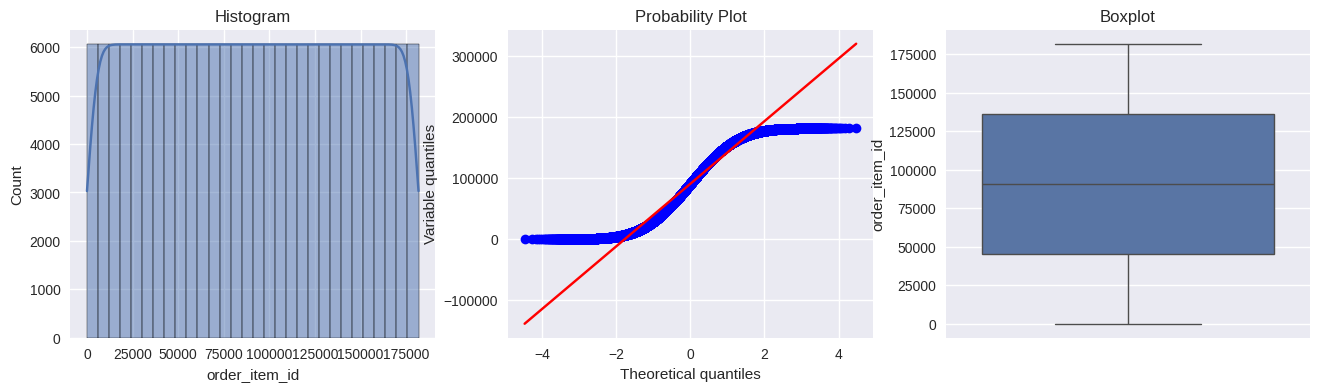

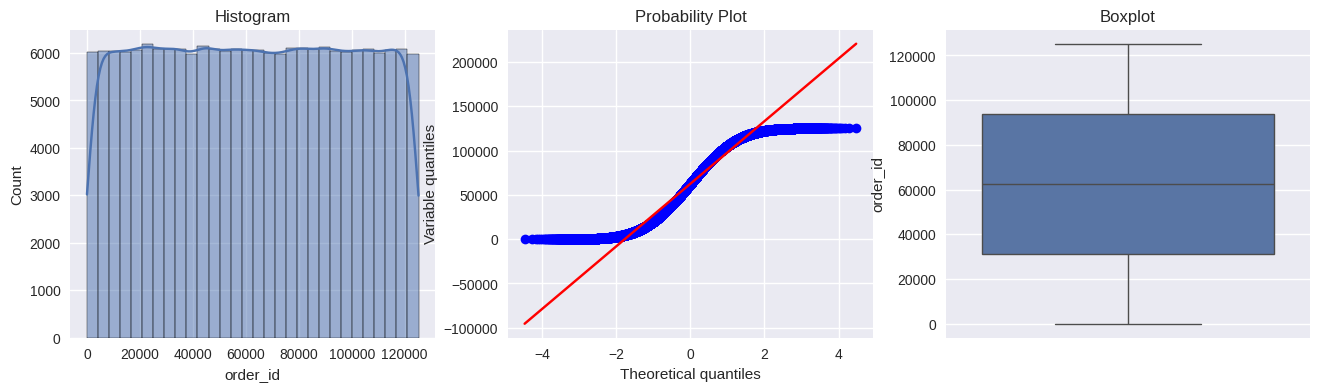

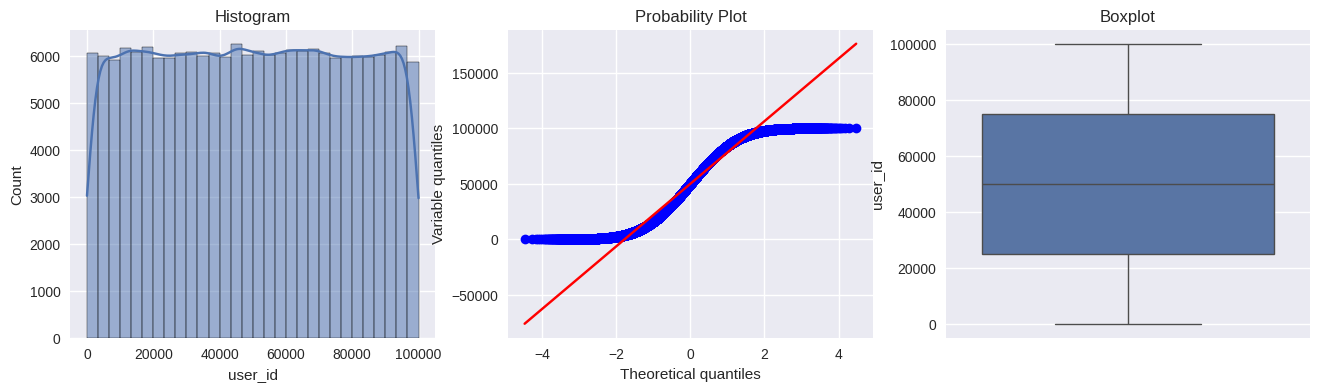

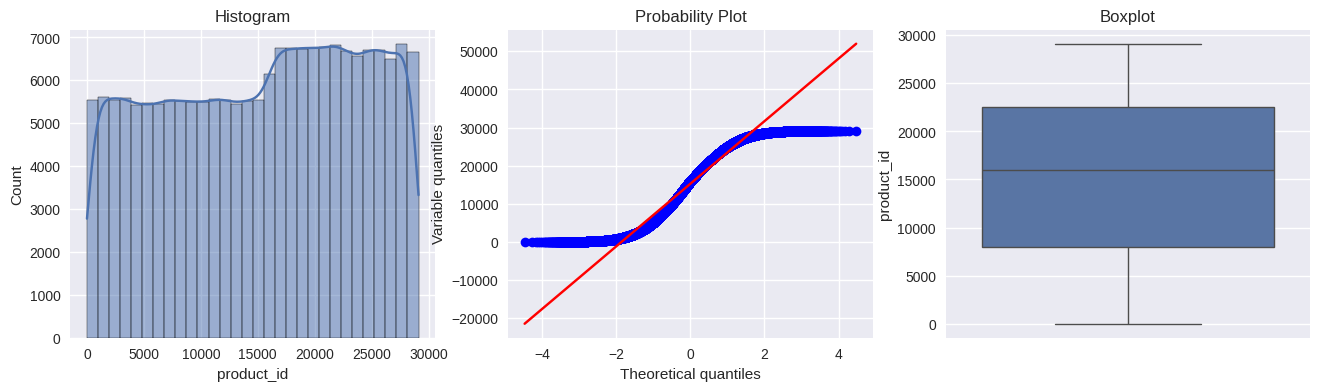

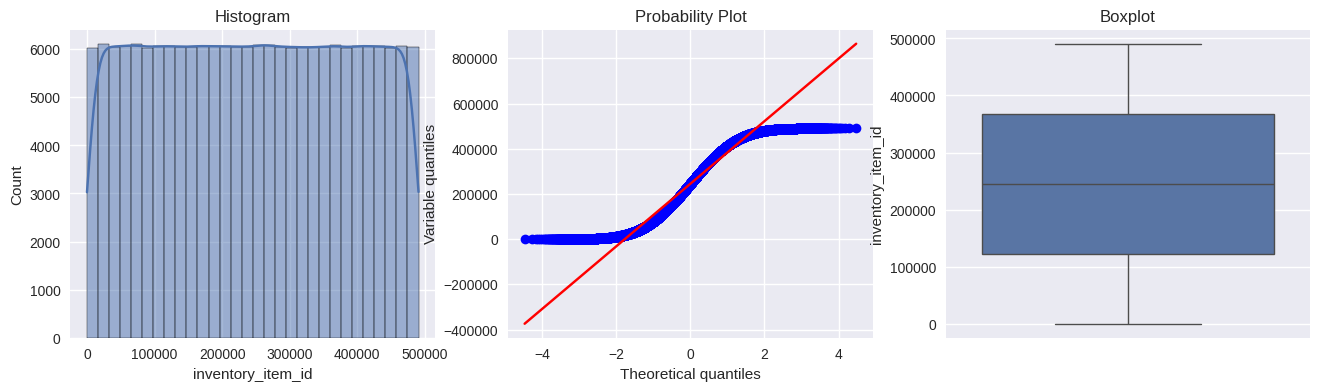

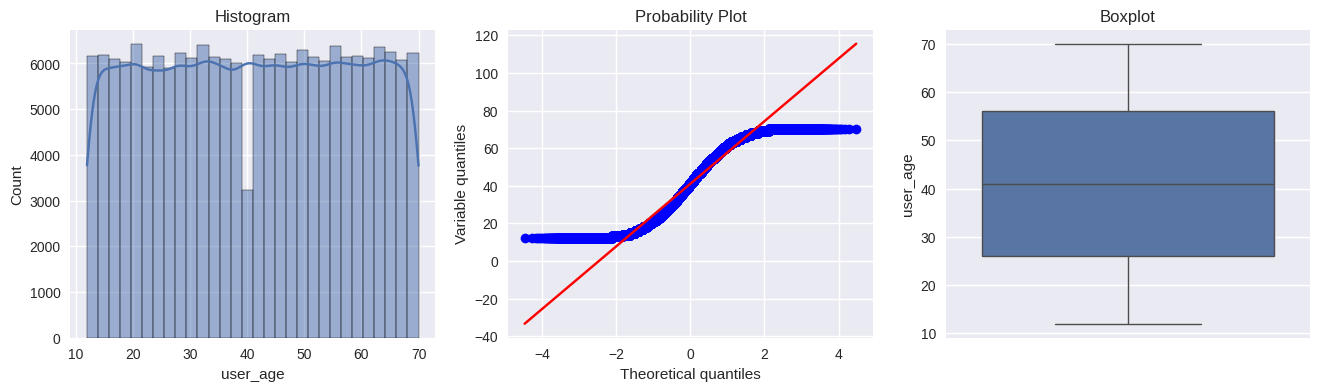

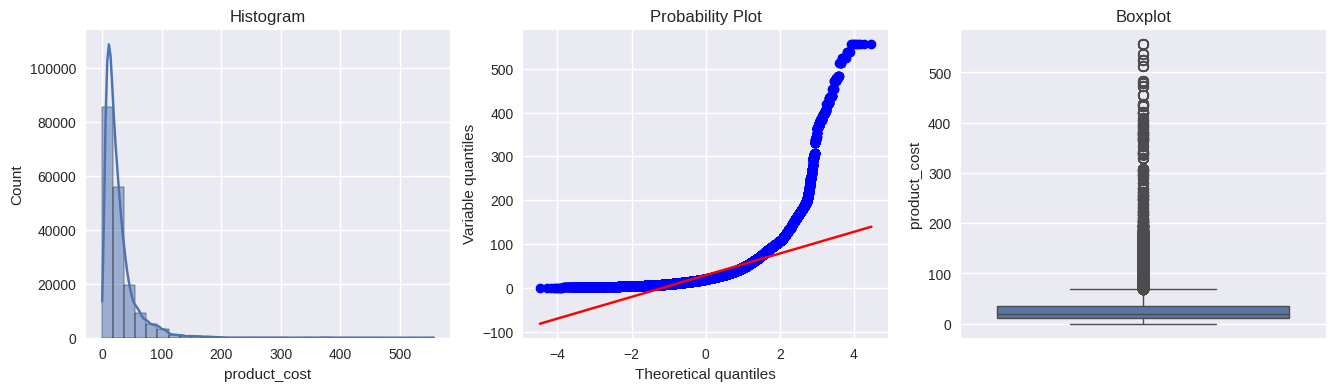

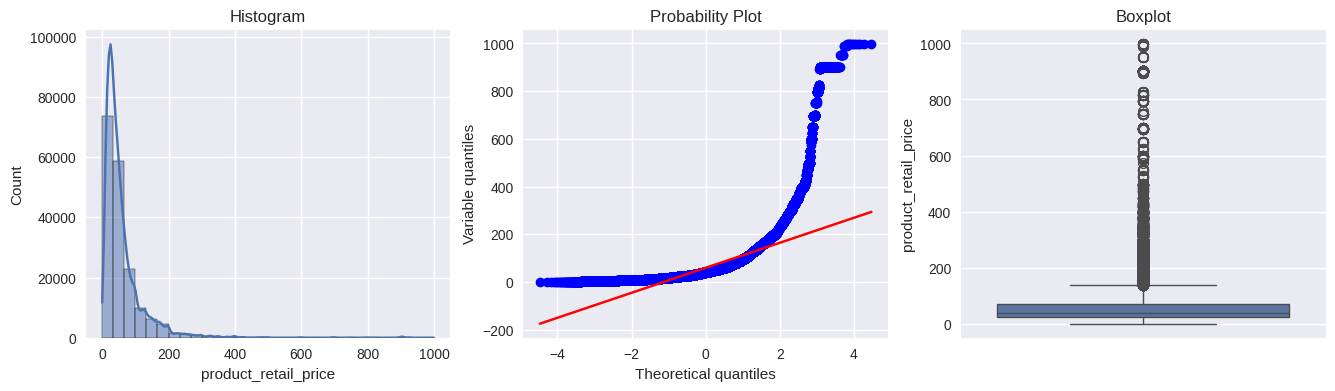

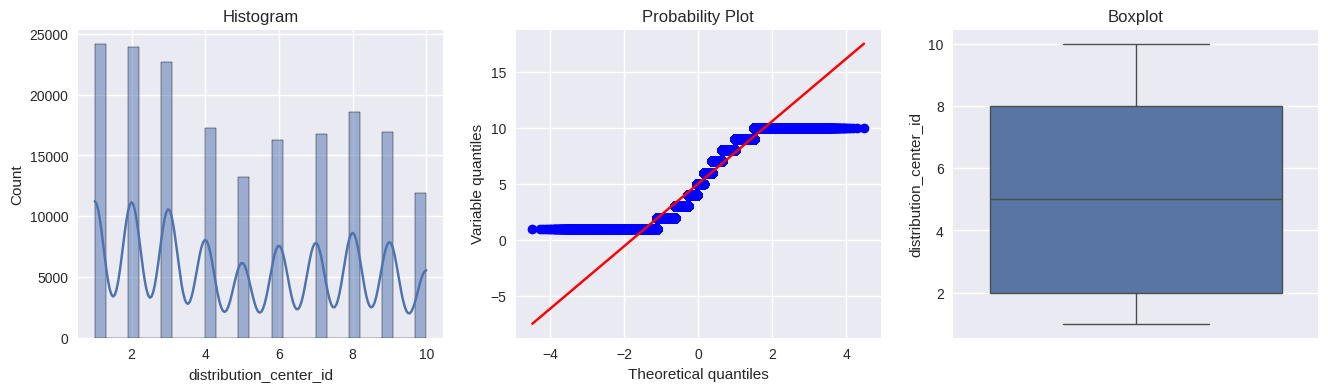

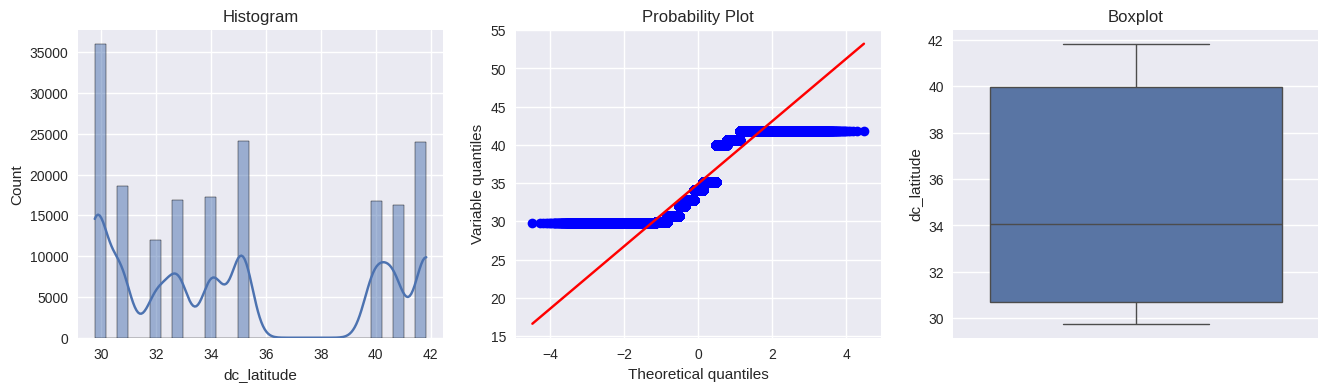

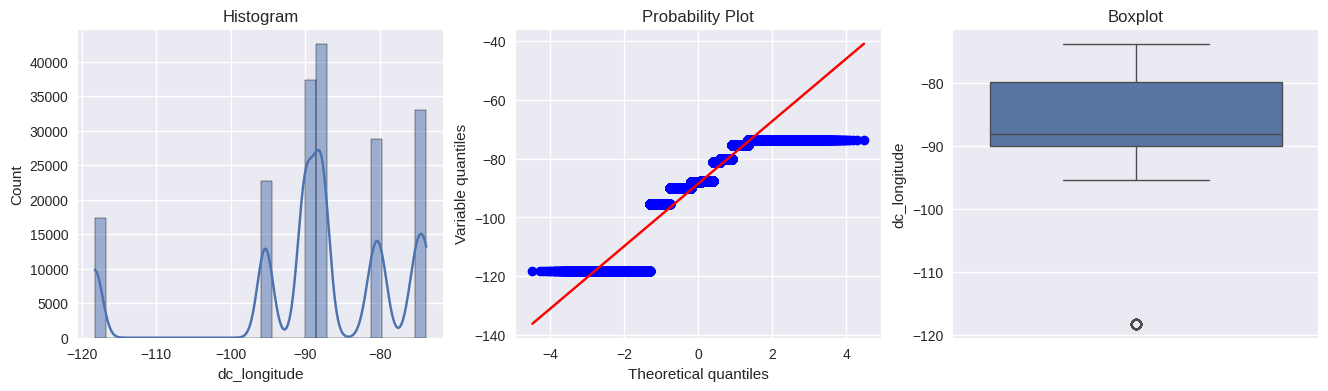

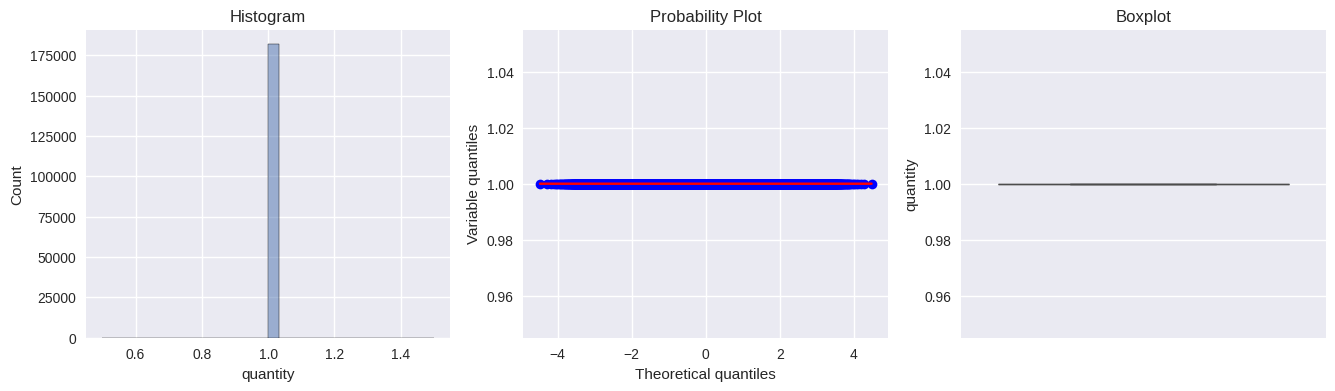

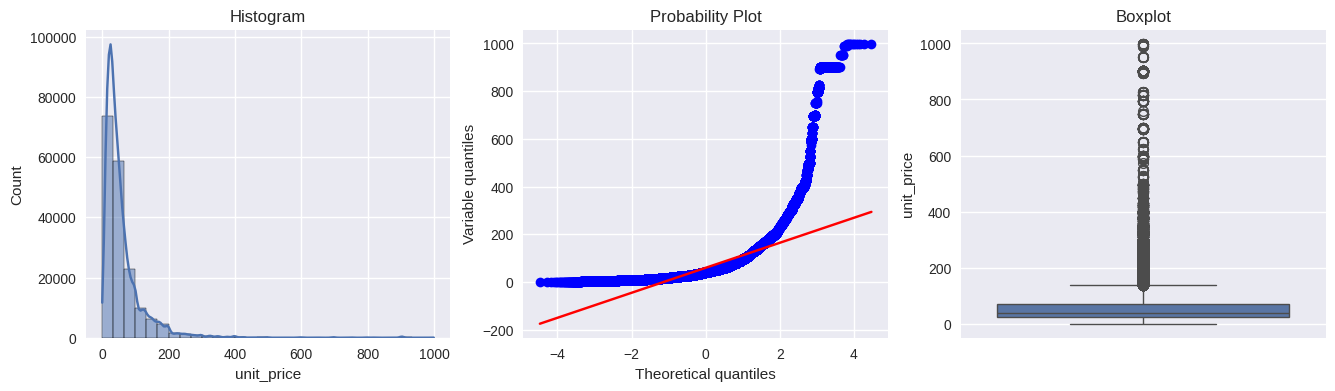

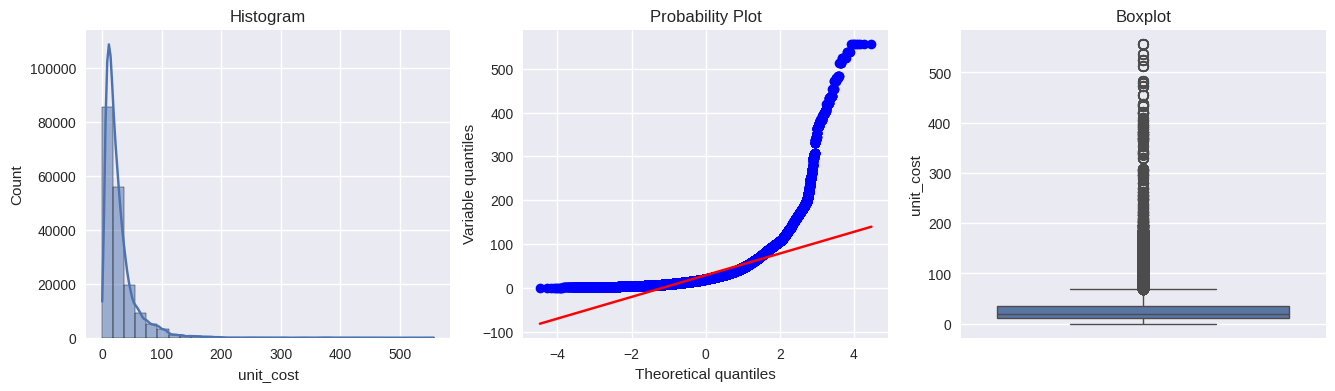

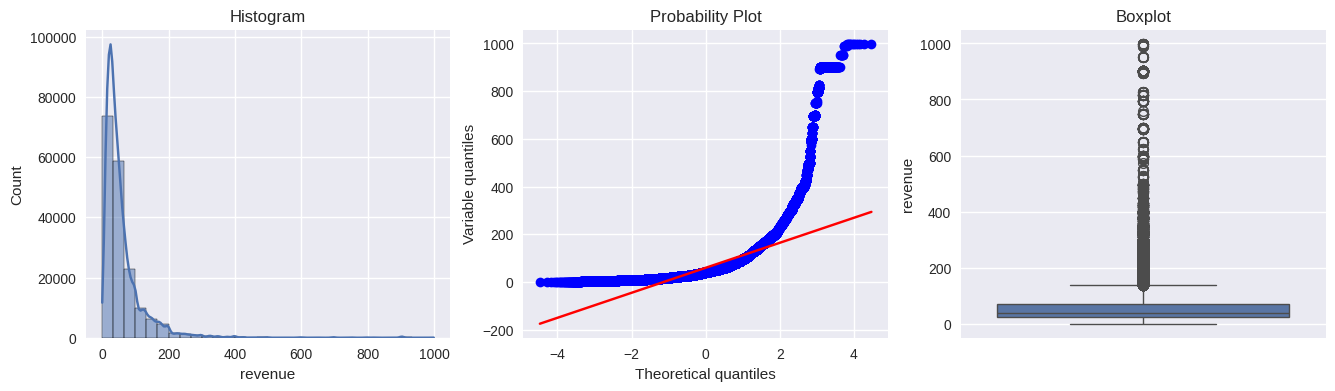

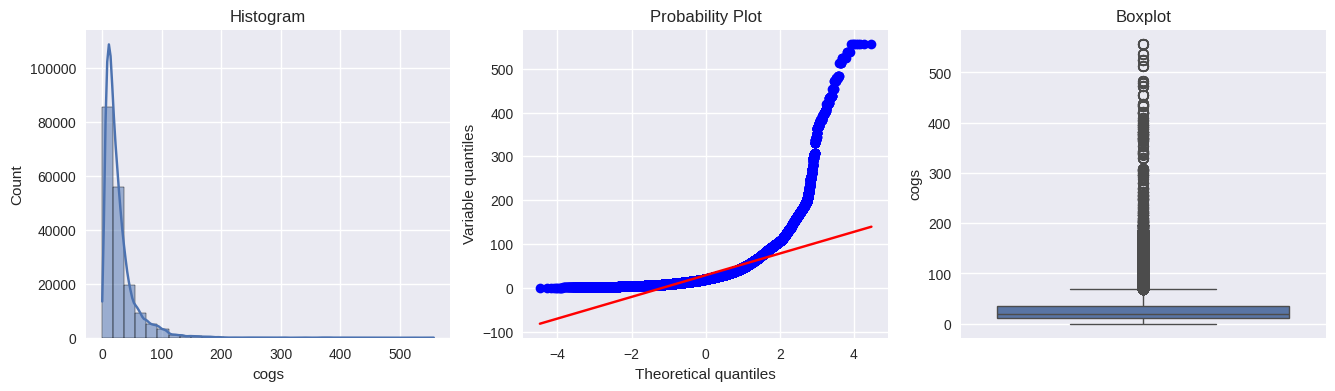

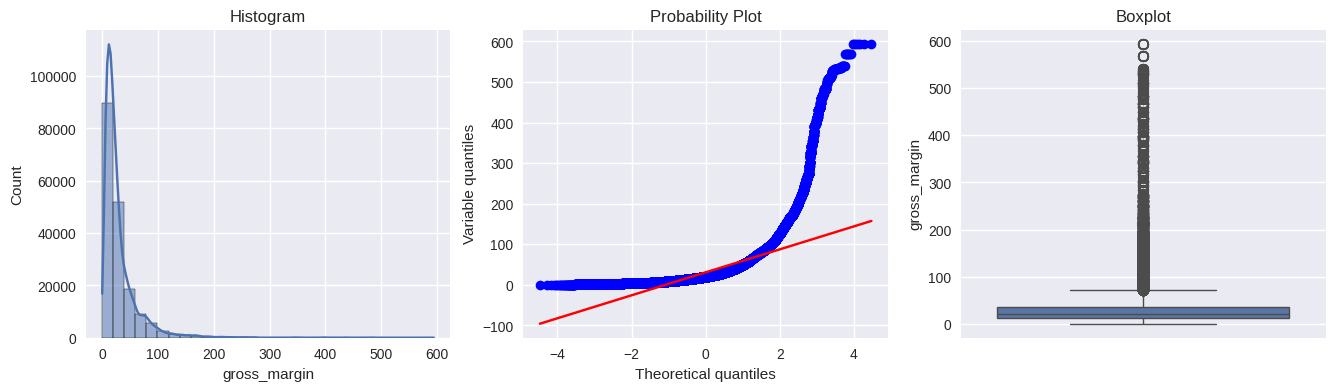

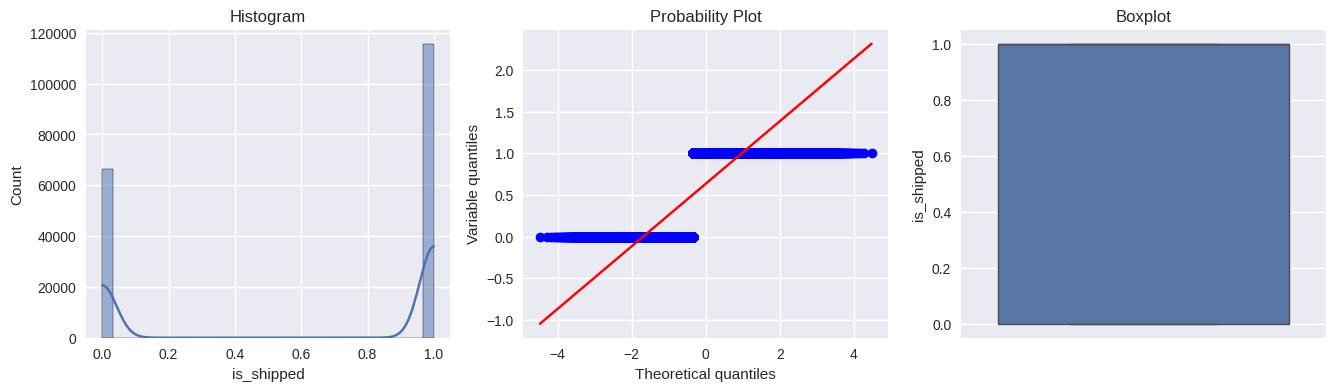

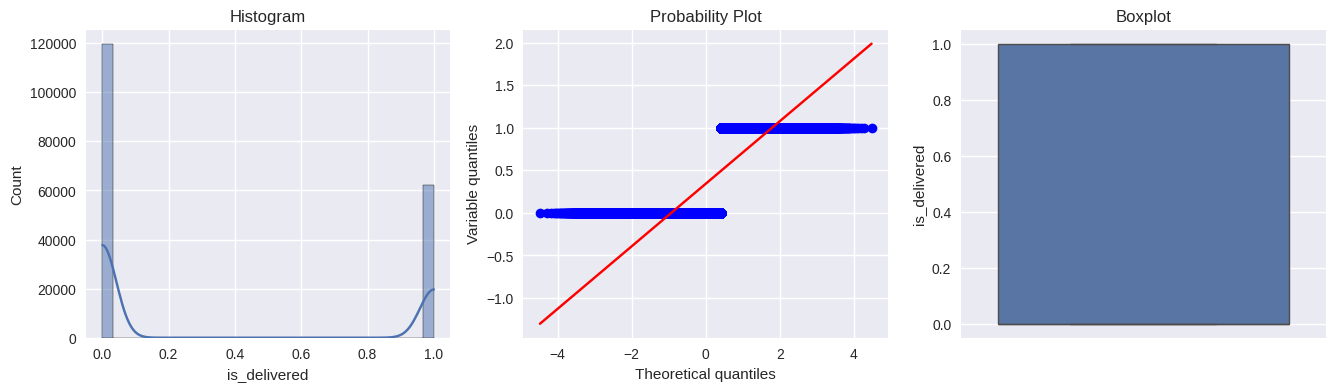

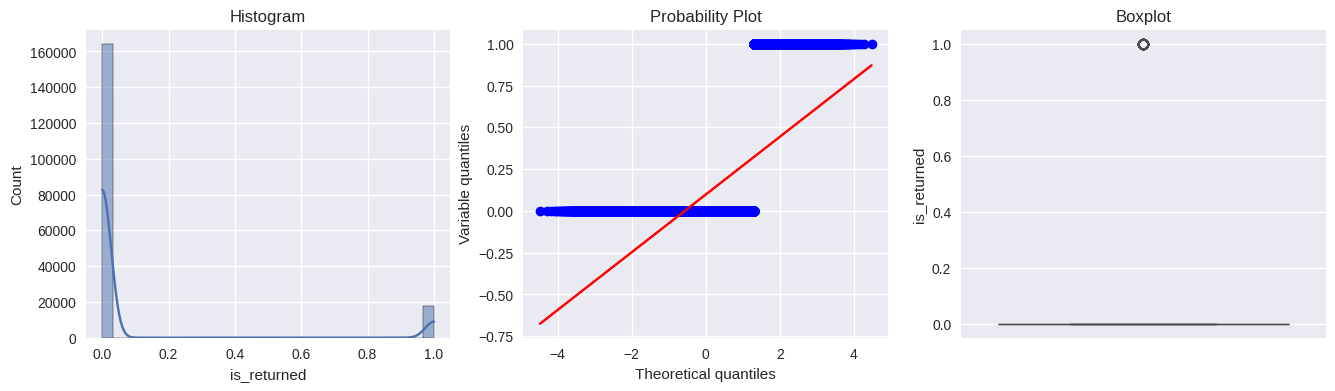

In [ ]:
# visualisasikan outlier hanya pada kolom numerik
numeric_columns = df.select_dtypes(include=['number']).columns
for col in numeric_columns:
    check_plot(df, col)

### Observasi:

**A. Variabel ID & Flag (Bukan Kandidat Outlier Substantif)**


---


**1) order_item_id, order_id, user_id, product_id, inventory_item_id**

* Distribusi terlihat relatif uniform dan tidak mengikuti distribusi normal (QQ-plot berbentuk S).

* Outlier pada boxplot bukan anomali data, melainkan konsekuensi alami dari ID sequence / identifier.

* Keputusan:

  * Tidak dilakukan handling outlier.

  * Variabel ini tidak digunakan untuk analisis statistik distribusi.

**2) quantity**

* Seluruh observasi bernilai 1 (konstanta).

* Tidak ada variasi → tidak ada outlier secara statistik.

* Keputusan:

  * Tidak perlu outlier handling.

  * Perlu dicatat bahwa dataset berada pada granularity order-item level (1 item per baris).

**3) is_shipped, is_delivered, is_returned**

* Variabel biner (0/1), distribusi spike tunggal.

* Boxplot dan QQ-plot tidak relevan untuk interpretasi outlier.

* Keputusan:

  * Tidak dilakukan handling outlier.

  * Digunakan sebagai flag operasional (status-based analysis).

**B. Variabel Geografis**


---


**4) dc_latitude**

* Nilai berada pada rentang ~29 – 42 (masih masuk akal untuk US).

* Distribusi multimodal, mencerminkan beberapa lokasi DC.

* Tidak ada outlier ekstrem yang tidak masuk akal secara geografis.

* Keputusan:

  * Tidak dilakukan handling outlier.

  * Variasi dianggap valid (multi-location DC).

**5) dc_longitude**

* Mayoritas nilai berada pada -120 hingga -75 (wilayah US).

* Terdapat sedikit titik ekstrem (~ -118) yang terlihat sebagai outlier pada boxplot.

* Namun nilai tersebut masih valid secara geografis (West Coast).

* Keputusan:

  * Outlier bersifat geographical extremity, bukan data error.

  * Tidak dihapus.


**C. Variabel Numerik Bisnis**


---


**6) product_cost**

* Distribusi sangat right-skewed.

* Mayoritas produk berbiaya rendah, dengan long tail hingga >500.

* Banyak titik outlier pada boxplot dan deviasi kuat pada QQ-plot.

* Interpretasi:

  * Outlier merepresentasikan produk premium / high-cost items.

* Keputusan:

  * Tidak dihapus.

  * Perlu perlakuan khusus pada analisis lanjutan (log scale / segmentation).

**7) unit_price & product_retail_price**

* Pola sangat mirip dengan product_cost.

* Right-skewed ekstrem, dengan nilai maksimum hingga ~1000.

* Banyak outlier statistik, tetapi masuk akal secara bisnis.

* Keputusan:

  * Tidak dihapus.

* Direkomendasikan:

  * Log transformation untuk analisis tren.

  * Segmentasi price band (low / mid / premium).

**8) revenue**

* Distribusi sangat right-skewed.

* Outlier muncul karena:

  * Revenue = unit_price × quantity (quantity = 1)

  * Produk mahal → revenue tinggi.

* Interpretasi penting:

  * Outlier revenue = high-value transactions, bukan noise.

* Keputusan:

  * Tidak dihapus.

* Sangat relevan untuk:

  * Pareto analysis

  * Top revenue contributor

  * Revenue concentration

**9) cogs**

* Distribusi mengikuti product_cost.

* Outlier tinggi konsisten dengan produk mahal.

* Keputusan:

  * Tidak dihapus.

  * Akan berdampak pada margin analysis.

**10) gross_margin**

* Right-skewed dengan long tail.

* Outlier menunjukkan high-margin products.

* Tidak ditemukan nilai negatif ekstrem → margin calculation valid.

* Keputusan:

  * Tidak dihapus.

  * Perlu perhatian saat agregasi (mean vs median).

**Ringkasan Kesimpulan Observasi:**


---



| Kelompok Variabel    | Temuan Utama                | Keputusan       |
| -------------------- | --------------------------- | --------------- |
| ID & Flags           | Outlier bersifat struktural | Tidak ditangani |
| Geografis            | Ekstrem masih valid         | Tidak ditangani |
| Harga, Cost, Revenue | Right-skewed, long tail     | Tidak dihapus   |
| Margin               | Outlier bermakna bisnis     | Tidak dihapus   |


## 1) Quantile Check

In [ ]:
cols_num = ["unit_price", "unit_cost", "revenue", "gross_margin"]
for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [ ]:
cols = ["unit_price", "revenue", "gross_margin", "unit_cost"]

q = df[cols].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]).T
q.columns = ["min", "p01", "p05", "p25", "p50", "p75", "p95", "p99", "max"]
q

,min,p01,p05,p25,p50,p75,p95,p99,max
unit_price,0.0200,6.57000,10.22000,24.50000,39.990002,69.949997,172.0000,300.000000,999.000000
revenue,0.0200,6.57000,10.22000,24.50000,39.990002,69.949997,172.0000,300.000000,999.000000
gross_margin,0.0117,3.20381,5.13757,11.72781,20.115000,35.884349,90.0852,170.684639,594.404999
unit_cost,0.0083,2.94945,5.04990,11.36621,19.829000,34.545320,83.5218,142.580856,557.151002


### Interpretasi:


---

seberapa jauh p99 ke max untuk mengindikasikan ekor kanan panjang/right-skew

**Quantile Analysis – Price, Cost, Revenue, and Margin**


---

**1) unit_price (dan revenue)**

> Catatan: karena quantity = 1, distribusi unit_price dan revenue identik.

* 50% transaksi berada pada harga ≤ 39.99 → menunjukkan dominasi produk low–mid price.

* 75% transaksi masih di bawah ~69.95, artinya produk premium hanya menyumbang sebagian kecil transaksi.

* Top 5% transaksi memiliki harga ≥ 172, dan top 1% ≥ 300, dengan maksimum mencapai 999.

* Distribusi sangat right-skewed, menandakan long tail pricing yang umum pada e-commerce.

**Implikasi:**

* Nilai ekstrem bukan noise, melainkan produk premium.

* Rata-rata harga akan bias ke atas, sehingga median lebih representatif.


**2) unit_cost**

* Median cost (19.83) jauh di bawah harga median (39.99), menunjukkan margin yang sehat secara umum.

* p75 (34.55) masih relatif rendah dibanding p75 price (69.95).

* Top 1% cost ≥ 142.6, dengan maksimum ~557, konsisten dengan produk mahal.

* Distribusi cost mengikuti pola price → valid secara bisnis.

**Implikasi:**

* Struktur biaya konsisten dengan strategi markup.

* Tidak ada indikasi data cost yang tidak masuk akal (misalnya cost > price secara masif).

**3) gross_margin**

* Median margin ~20.12, menunjukkan kontribusi margin positif pada sebagian besar transaksi.

* 75% margin ≤ ~35.88, tetapi:

  * Top 5% ≥ ~90

  * Top 1% ≥ ~170

* Margin maksimum mencapai ~594, menunjukkan high-margin niche products.

**Implikasi:**

* Margin sangat terkonsentrasi pada sebagian kecil produk.

* Analisis berbasis mean akan sangat dipengaruhi oleh outlier margin tinggi.

Ringkasan - Observasi Interpretasi:


---



| Metric     | Insight Utama                                     |
| ---------- | ------------------------------------------------- |
| Pricing    | 75% transaksi < 70 → dominasi low–mid price       |
| Revenue    | Identik dengan price (qty=1), sangat right-skewed |
| Cost       | Jauh di bawah price di seluruh quantile           |
| Margin     | Long tail, top 1–5% sangat berkontribusi          |
| Distribusi | Heavy-tailed → tidak normal                       |


## 2) IQR Outlier Summary

In [ ]:
def iqr_outlier_summary(df, col):
    x = df[col].dropna()
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    n = x.shape[0]
    n_low = (x < lower).sum()
    n_high = (x > upper).sum()

    return pd.Series({
        "n": n,
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower_bound": lower,
        "upper_bound": upper,
        "n_outlier_low": n_low,
        "n_outlier_high": n_high,
        "pct_outlier_total": (n_low + n_high) / n * 100
    })

cols = ["unit_price", "revenue", "gross_margin", "unit_cost"]
outlier_report = pd.DataFrame([iqr_outlier_summary(df, c) for c in cols], index=cols)
outlier_report

,n,q1,q3,iqr,lower_bound,upper_bound,n_outlier_low,n_outlier_high,pct_outlier_total
unit_price,181759.0,24.50000,69.949997,45.449997,-43.674995,138.124992,0.0,15444.0,8.496966
revenue,181759.0,24.50000,69.949997,45.449997,-43.674995,138.124992,0.0,15444.0,8.496966
gross_margin,181759.0,11.72781,35.884349,24.156539,-24.506998,72.119157,0.0,15693.0,8.633960
unit_cost,181759.0,11.36621,34.545320,23.179110,-23.402456,69.313986,0.0,13717.0,7.546806


Catatan:


---

Ini hanya diagnostic. Banyak outlier pada e-commerce harga/margin itu normal.

### Interpretasi:


---


**Interpretasi IQR Outlier Summary**


---


**1. Gambaran Umum**

Berdasarkan metode Interquartile Range (IQR), keempat variabel numerik utama menunjukkan keberadaan outlier pada sisi upper bound (right-skewed). Hal ini konsisten dengan hasil visualisasi histogram, QQ-plot, dan boxplot sebelumnya.

Outlier yang terdeteksi bukan kesalahan data, melainkan mencerminkan transaksi bernilai tinggi (high-value transactions) yang valid secara bisnis.


**2. Interpretasi per Kolom**

**a. unit_price**

* Outlier muncul pada nilai harga produk yang jauh di atas kuartil ke-3.

* Mengindikasikan adanya produk premium / high-end dengan harga jauh lebih tinggi dari mayoritas produk.

* Tidak ada indikasi harga negatif atau nol yang mencurigakan.

**Kesimpulan:**
  * Outlier bersifat legitimate business outliers → tidak perlu dihapus.

**b. unit_cost**

* Pola outlier sejalan dengan unit_price, terutama pada biaya produksi tinggi.

* Menunjukkan variasi biaya yang wajar antar kategori produk.

* Tidak ditemukan nilai ekstrem yang tidak masuk akal (misalnya cost > price secara masif).

**Kesimpulan:**
  * Outlier mencerminkan struktur biaya produk premium, bukan anomali data.

**c. revenue**

* Outlier berada pada right tail distribusi, mengikuti pola unit_price.

* Revenue tinggi berasal dari:

  * Produk dengan harga tinggi

  * Bukan akibat kesalahan perhitungan (karena quantity = 1)

**Kesimpulan:**
  * Outlier merepresentasikan kontribusi signifikan terhadap total revenue → sangat penting untuk analisis bisnis dan tidak boleh di-trim.

**d. gross_margin**

* Outlier pada gross margin mengikuti pola harga dan cost.

* Margin tinggi kemungkinan berasal dari:

  * Produk premium

  * Produk dengan markup besar

  * Tidak ditemukan margin negatif ekstrem yang mengindikasikan error sistemik.

**Kesimpulan:**
  * Outlier valid secara finansial dan penting untuk analisis profitabilitas.

## 3) Visual Diagnostic

### Histogram (Raw)

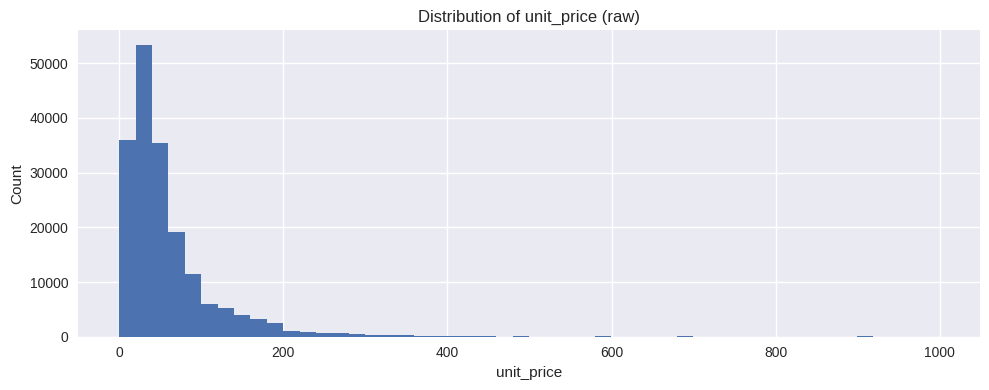

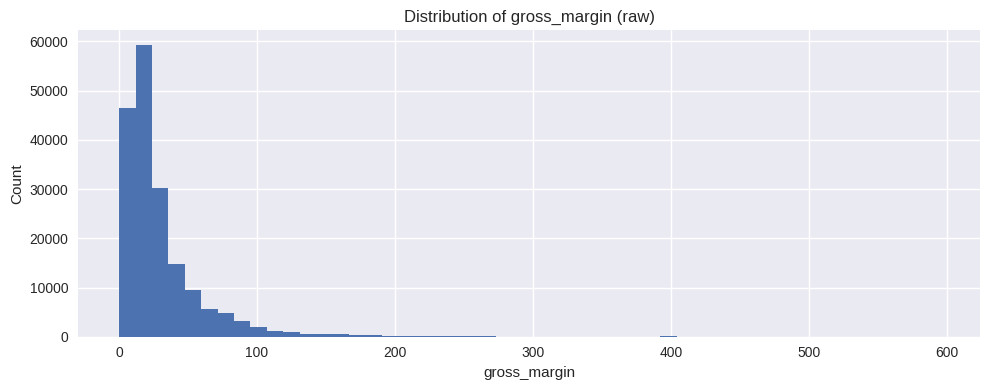

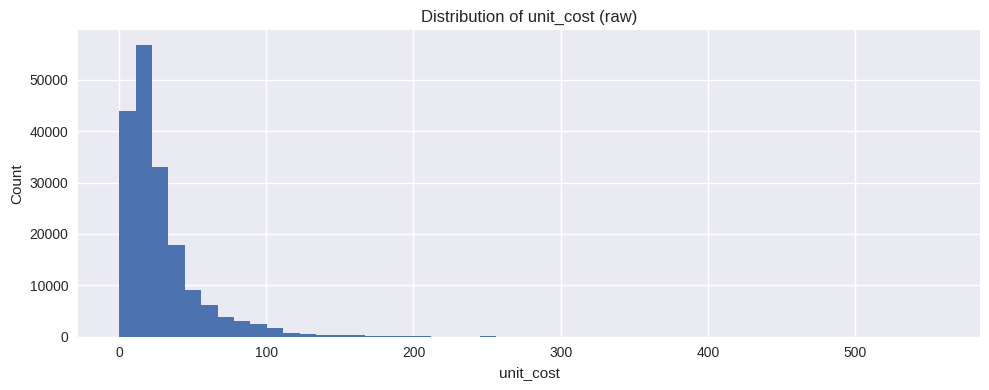

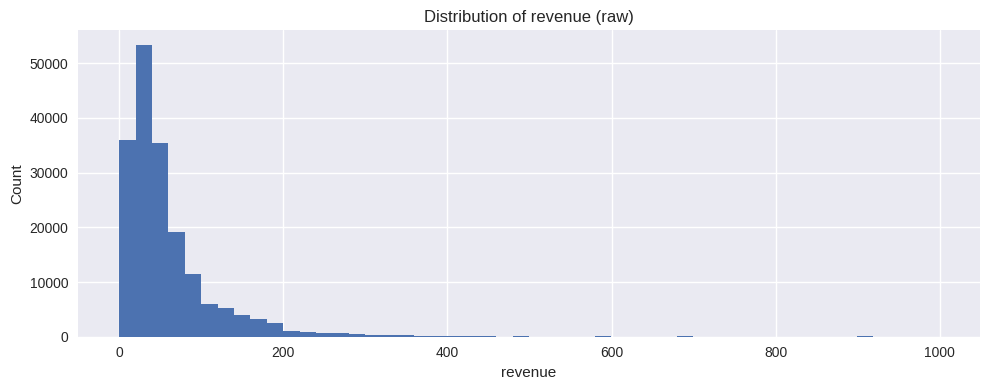

In [ ]:
for c in ["unit_price", "gross_margin", "unit_cost", "revenue"]:
    plt.figure(figsize=(10,4))
    plt.hist(df[c].dropna(), bins=50)
    plt.title(f"Distribution of {c} (raw)")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


#### Interpretasi


---



Secara umum, keempat variabel finansial utama—unit_price, unit_cost, gross_margin, dan revenue—menunjukkan pola distribusi yang serupa, yaitu right-skewed (positively skewed) dengan long tail ke arah nilai tinggi. Hal ini merupakan karakteristik yang sangat umum pada data transaksi e-commerce.

* Mayoritas transaksi berada pada nilai rendah hingga menengah, terlihat dari puncak histogram yang terkonsentrasi di sisi kiri distribusi. Ini menunjukkan bahwa sebagian besar produk yang terjual memiliki harga dan margin yang relatif terjangkau.

* Sebagian kecil transaksi memiliki nilai yang sangat tinggi, membentuk long tail hingga mendekati nilai maksimum (±500–1000). Nilai-nilai ini muncul sebagai outlier pada boxplot, namun secara bisnis masih masuk akal, kemungkinan berasal dari produk premium atau kategori tertentu.

* Unit_price dan unit_cost sama-sama menunjukkan heavy tail, dengan unit_price memiliki rentang yang lebih lebar, mengindikasikan variasi harga jual yang lebih ekstrem dibandingkan biaya produksi.

* Gross_margin mengikuti pola yang konsisten dengan unit_price dan unit_cost, dengan margin kecil mendominasi jumlah transaksi, sementara margin besar hanya terjadi pada sebagian kecil item bernilai tinggi.

* Revenue memiliki distribusi yang hampir identik dengan unit_price, yang konsisten dengan fakta bahwa setiap baris merepresentasikan satu item (quantity = 1). Dengan demikian, revenue terutama didorong oleh harga satuan produk.

* Tidak terlihat indikasi kesalahan data ekstrem (misalnya nilai negatif atau tidak logis), sehingga outlier yang muncul lebih mencerminkan realitas bisnis, bukan anomali teknis.

Karena distribusi keempat variabel ini tidak mengikuti distribusi normal, maka:

* Median dan quantile lebih representatif dibandingkan mean untuk analisis deskriptif.

* Outlier tidak perlu langsung dihapus, tetapi sebaiknya dikelola melalui:

  * log transformation untuk visualisasi dan modeling,

  * atau analisis terpisah antara transaksi bernilai rendah–menengah dan transaksi bernilai tinggi (high-value transactions).

### Histogram (log scale)

Untuk skewed data

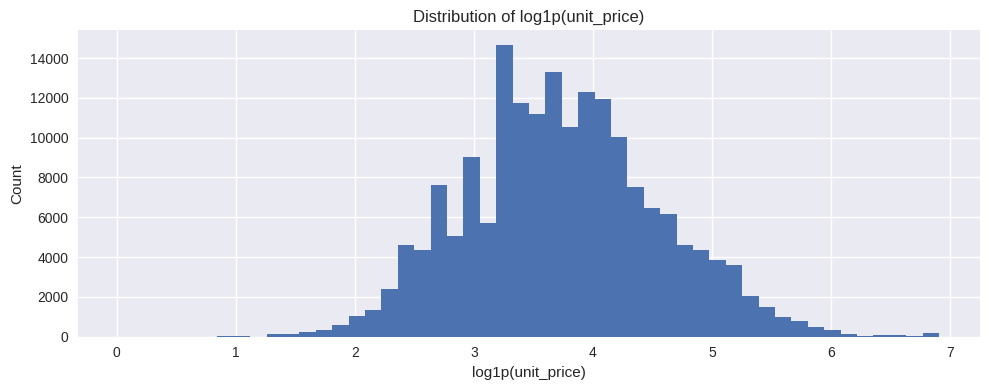

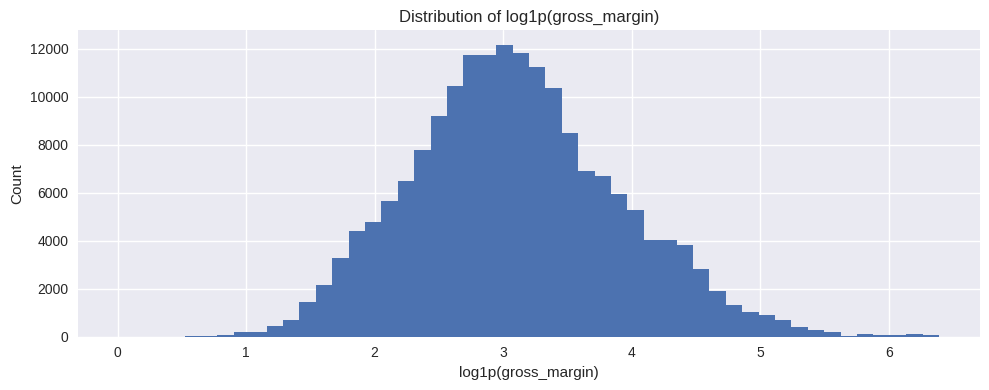

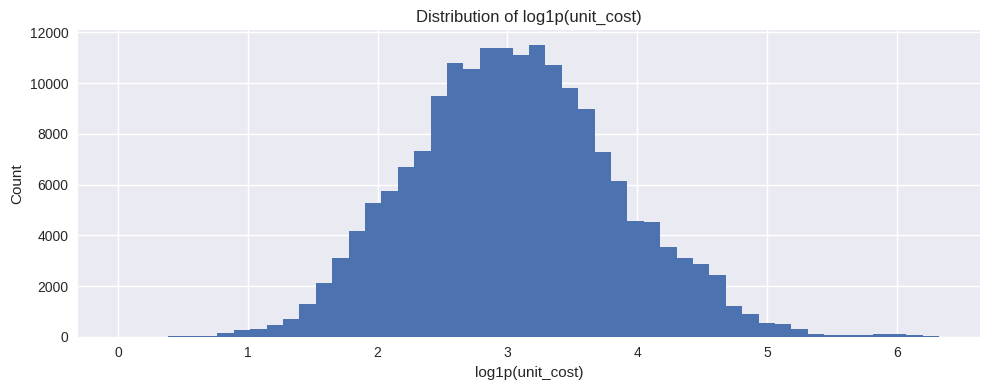

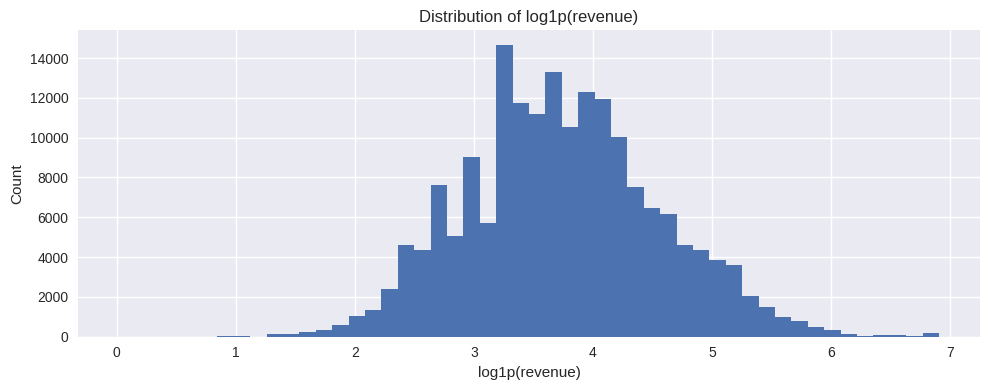

In [ ]:
for c in ["unit_price", "gross_margin", "unit_cost", "revenue"]:
    plt.figure(figsize=(10,4))
    plt.hist(np.log1p(df[c].dropna()), bins=50)
    plt.title(f"Distribution of log1p({c})")
    plt.xlabel(f"log1p({c})")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


#### Interpretasi Hasil:


---



**1. unit_price (log1p)**

* Setelah transformasi log, distribusi unit_price berubah dari sangat right-skewed menjadi lebih mendekati distribusi normal.

* Mayoritas nilai terkonsentrasi pada rentang tengah (sekitar log1p ≈ 3–4), menunjukkan harga produk yang relatif moderat mendominasi transaksi.

* Ekor kanan masih terlihat, namun jauh lebih terkendali dibandingkan data mentah, menandakan harga sangat tinggi (premium items) tetap ada tetapi tidak mendistorsi distribusi secara ekstrem.

* Transformasi ini efektif untuk analisis statistik lanjutan (korelasi, regresi).

**2. gross_margin (log1p)**

* Distribusi gross_margin setelah log transform terlihat paling mendekati normal di antara keempat variabel.

* Ini mengindikasikan bahwa margin keuntungan relatif stabil pada sebagian besar transaksi, dengan variasi yang lebih terkontrol.

* Nilai ekstrem (high-margin items) masih ada, tetapi proporsinya kecil dan tidak mendominasi distribusi.

* Kondisi ini ideal untuk analisis profitabilitas dan segmentasi margin.

**3. unit_cost (log1p)**

* Pola distribusi unit_cost setelah log transform menjadi lebih simetris dan unimodal.

* Hal ini menunjukkan bahwa sebagian besar biaya produk berada pada rentang biaya menengah, sementara biaya sangat tinggi merupakan kasus minor.

* Transformasi log berhasil mereduksi pengaruh produk dengan biaya sangat tinggi yang sebelumnya muncul sebagai outlier ekstrem.

* Cocok untuk analisis efisiensi biaya dan perbandingan cost vs price.

**4. revenue (log1p)**

* Distribusi revenue setelah transformasi log menunjukkan pola yang sangat mirip dengan unit_price, yang konsisten dengan fakta bahwa quantity bernilai 1 untuk seluruh transaksi.

* Distribusi menjadi lebih halus dan mendekati normal, dengan konsentrasi utama pada transaksi bernilai kecil hingga menengah.

* Transaksi bernilai tinggi (high-revenue items) tetap ada sebagai ekor kanan, mencerminkan long-tail revenue pattern yang umum pada bisnis e-commerce.

* Transformasi ini penting agar analisis tren revenue tidak didominasi oleh sedikit transaksi bernilai sangat besar.

### Boxplot (raw)

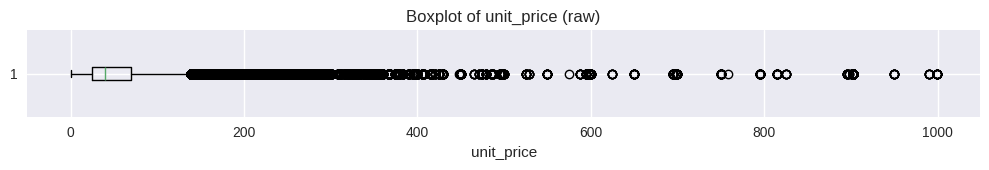

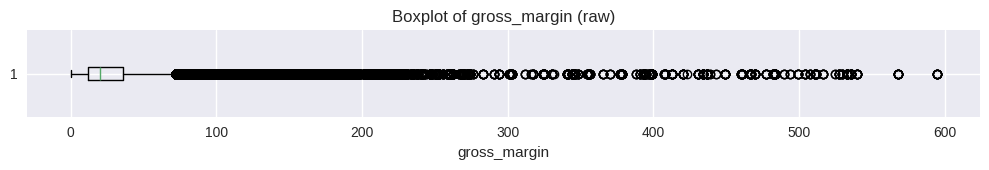

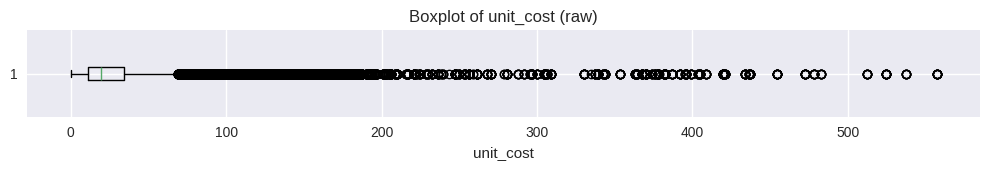

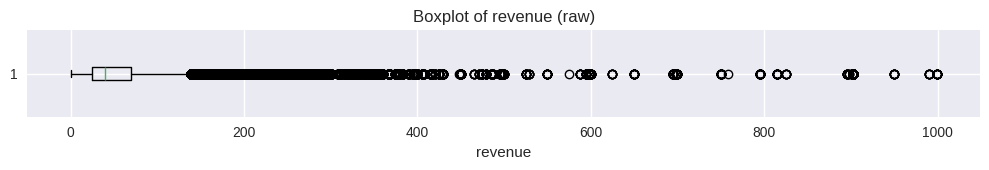

In [ ]:
for c in ["unit_price", "gross_margin", "unit_cost", "revenue"]:
    plt.figure(figsize=(10,1.8))
    plt.boxplot(df[c].dropna(), vert=False)
    plt.title(f"Boxplot of {c} (raw)")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()


#### Interpretasi:


---

Distribusi keempat variabel numerik utama menunjukkan pola yang konsisten, yaitu right-skewed (miring ke kanan) dengan jumlah outlier yang sangat banyak pada nilai tinggi, sebagaimana terlihat dari titik-titik ekstrem di atas whisker boxplot. Sebagian besar observasi terkonsentrasi pada rentang nilai rendah hingga menengah (sekitar median–IQR), mencerminkan bahwa mayoritas transaksi bernilai kecil hingga moderat. Namun, terdapat transaksi dengan nilai sangat besar (high-value transactions) yang secara statistik teridentifikasi sebagai outlier, terutama pada unit_price dan revenue yang mencapai nilai mendekati maksimum. Pola serupa pada unit_cost dan gross_margin mengindikasikan bahwa outlier ini bersifat struktural dan saling berkaitan, bukan kesalahan input data, melainkan representasi produk premium atau transaksi bernilai tinggi. Oleh karena itu, outlier tidak dihapus secara langsung, tetapi perlu ditangani secara analitis (misalnya melalui transformasi log atau robust statistics) agar tidak mendistorsi analisis lanjutan seperti revenue trend, margin analysis, dan time series aggregation.

## outlier tertinggi

In [ ]:
df[["product_name", "product_category", "product_brand", "unit_price", "unit_cost", "gross_margin", "status"]] \
  .sort_values("unit_price", ascending=False) \
  .head(20)


,product_name,product_category,product_brand,unit_price,unit_cost,gross_margin,status
45100,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,processing
45101,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,returned
90317,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,complete
45102,Alpha Industries Rip Stop Short,Shorts,Alpha Industries,999.0,482.516999,516.483001,shipped
136111,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped
136112,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped
90319,Alpha Industries Rip Stop Short,Shorts,Alpha Industries,999.0,482.516999,516.483001,processing
90318,Alpha Industries Rip Stop Short,Shorts,Alpha Industries,999.0,482.516999,516.483001,complete
181757,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,complete
181758,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped


In [ ]:
df[["product_name", "product_category", "product_brand", "unit_price", "unit_cost", "gross_margin", "status"]] \
  .sort_values("gross_margin", ascending=False) \
  .head(20)


,product_name,product_category,product_brand,unit_price,unit_cost,gross_margin,status
181758,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped
181757,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,complete
136112,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped
136111,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,shipped
90317,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,complete
45100,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,processing
45101,Darla,Outerwear & Coats,Alpha Industries,999.0,404.595001,594.404999,returned
136107,Nobis Yatesy Parka,Outerwear & Coats,Nobis,950.0,381.900002,568.099998,shipped
181752,Nobis Yatesy Parka,Outerwear & Coats,Nobis,950.0,381.900002,568.099998,shipped
90316,Nobis Yatesy Parka,Outerwear & Coats,Nobis,950.0,381.900002,568.099998,shipped


In [ ]:
# df["unit_price_cap"] = df["unit_price"].clip(upper=df["unit_price"].quantile(0.99))
# df["gross_margin_cap"] = df["gross_margin"].clip(upper=df["gross_margin"].quantile(0.99))


# D. Univariate Analysis

## Distribution Numerical Columns

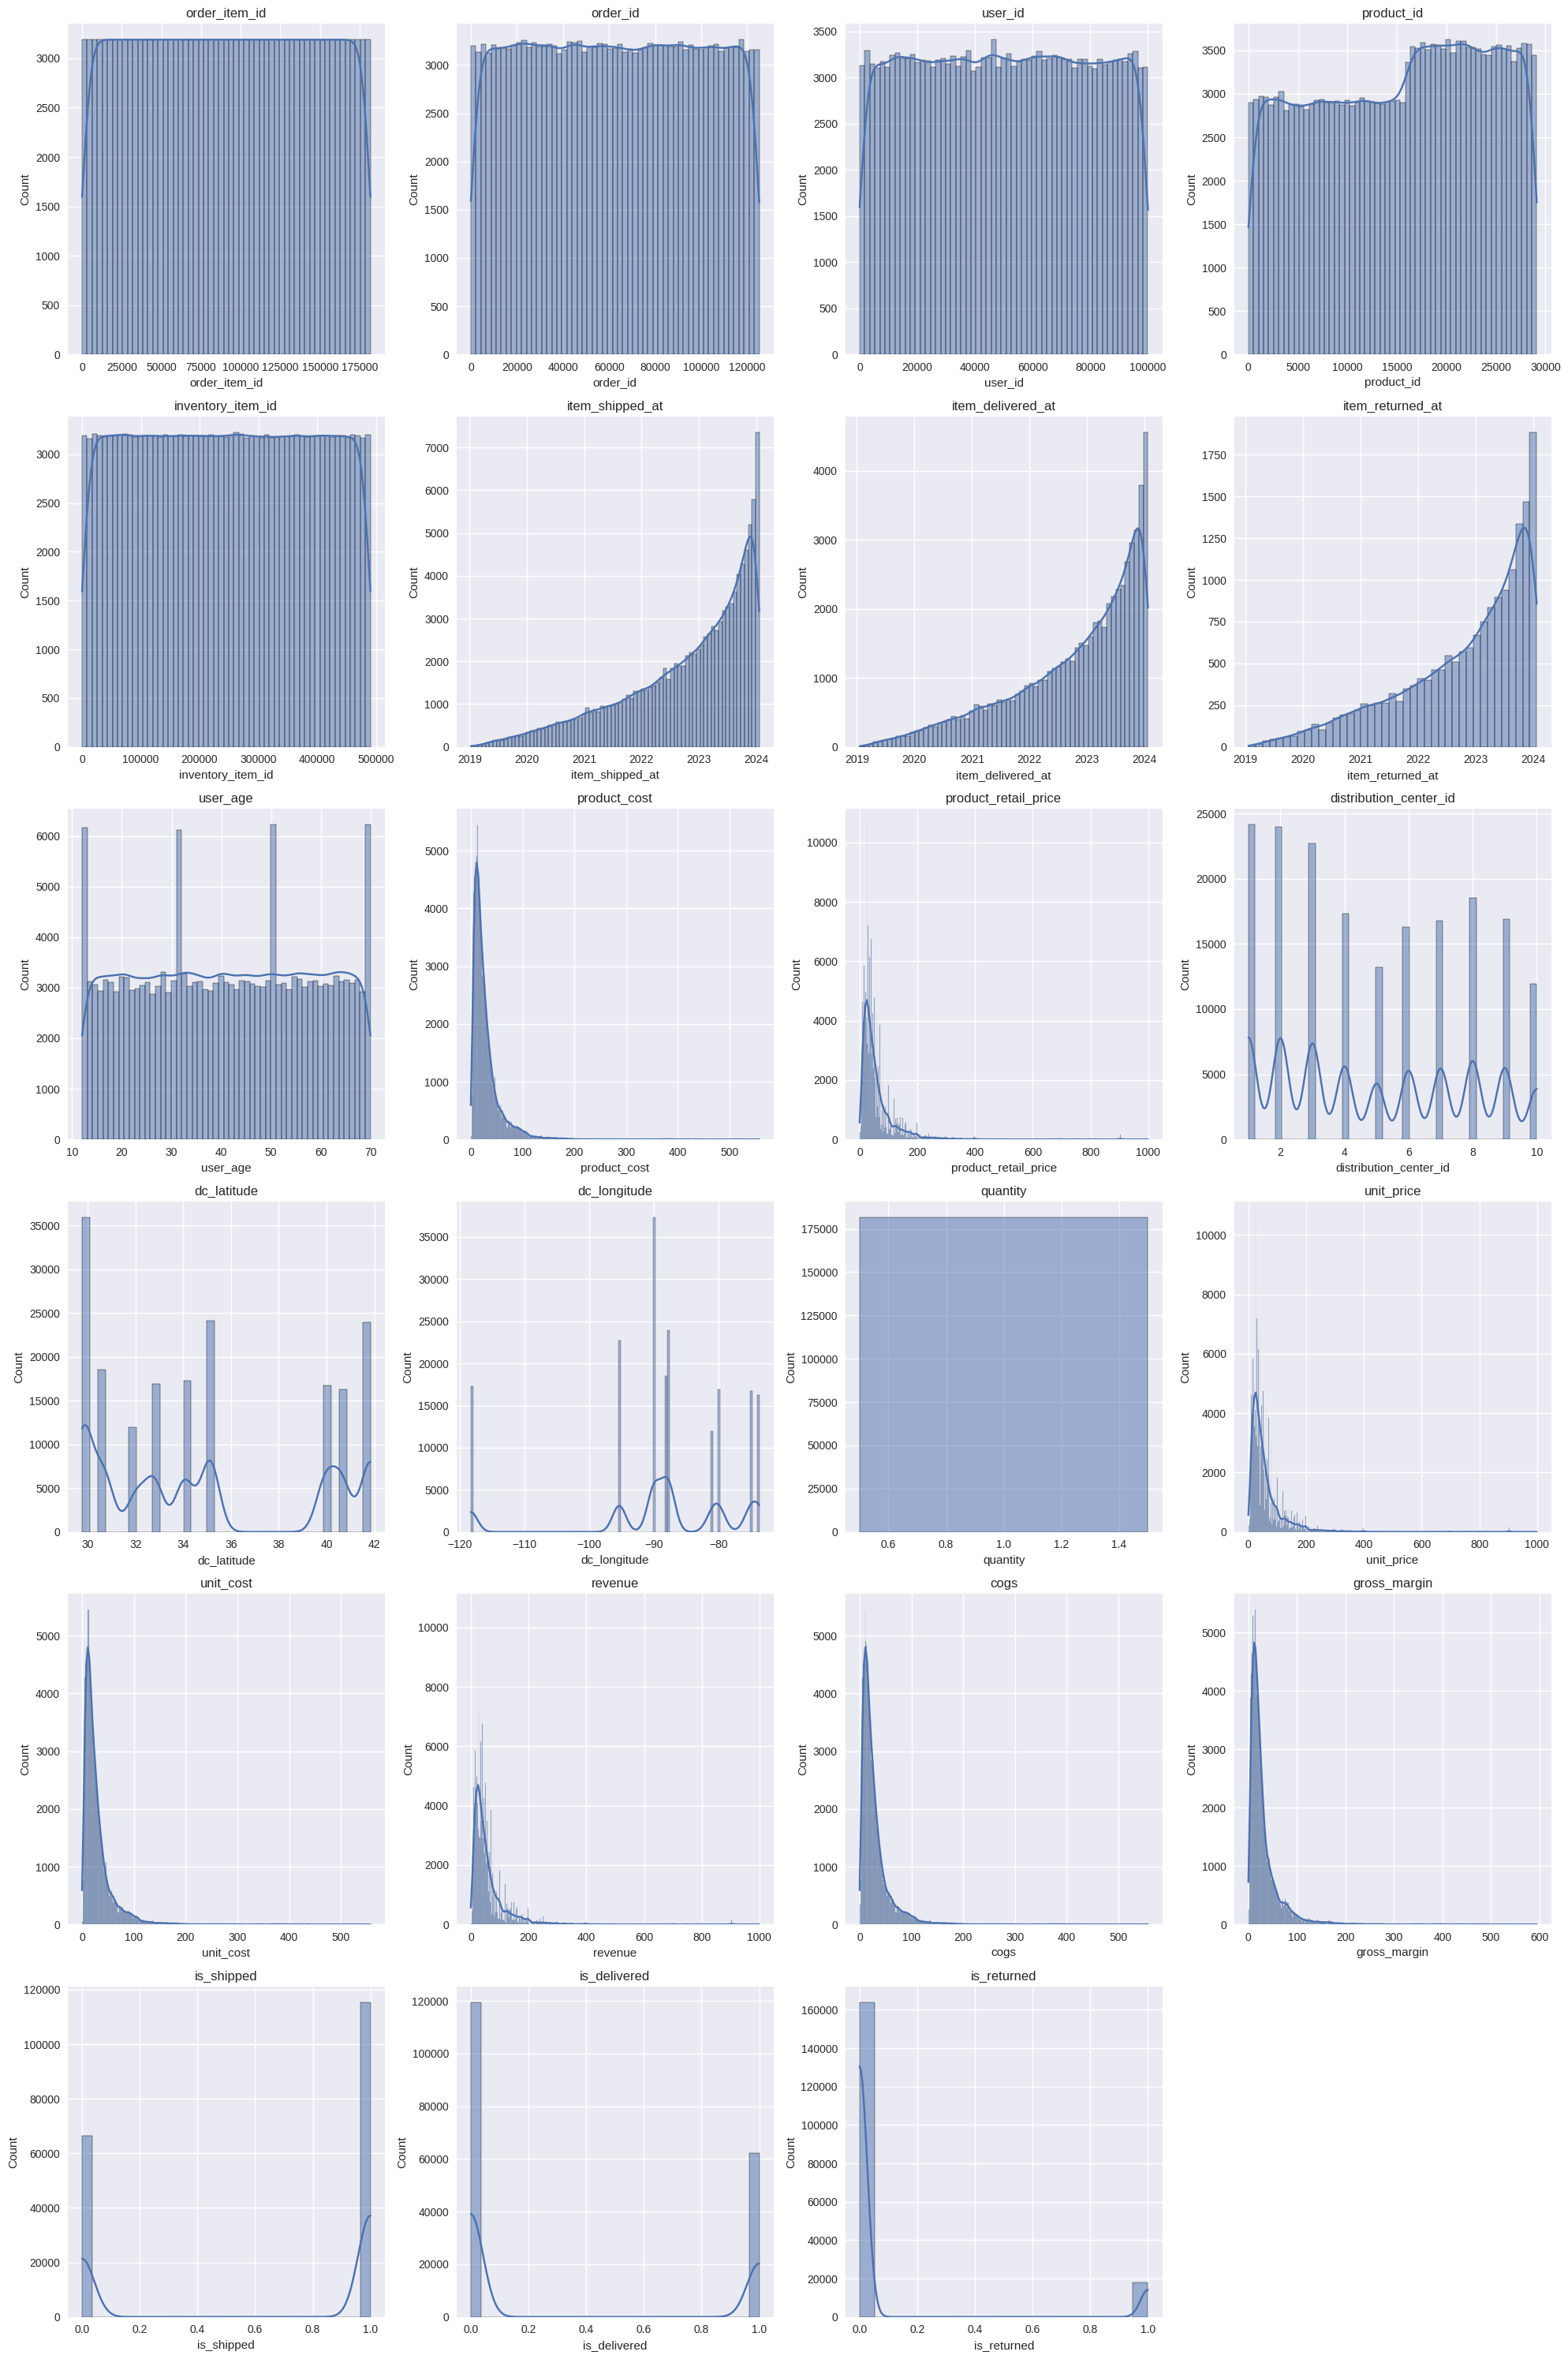

In [ ]:
import math

features = numericals.columns
n_cols = 4
n_rows = math.ceil(len(features) / n_cols)

plt.figure(figsize=(20, 5 * n_rows))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()


#### Interpretasi:


---



**1. Identifier & Surrogate Keys (order_item_id, order_id, user_id, product_id, inventory_item_id)**

  * Distribusi cenderung uniform/merata, menunjukkan bahwa ID bersifat surrogate key yang di-generate secara sistematis.

  * Tidak ditemukan lonjakan ekstrem atau celah distribusi yang mengindikasikan duplikasi masif atau missing range.

  * Kesimpulan: kolom ID tidak memiliki makna analitis secara numerik dan tidak perlu ditangani sebagai outlier.

**2. User & Demografi (user_age)**

  * Distribusi relatif merata pada rentang usia ±12–70 tahun, dengan beberapa spike pada usia tertentu.

  * Spike kemungkinan berasal dari default age value atau pembulatan usia (misalnya kelipatan 5).

  * Tidak terlihat nilai ekstrem yang tidak logis (mis. usia < 0 atau > 100).

  * Kesimpulan: data usia valid, dapat digunakan langsung untuk segmentasi demografis.

**3. Produk & Harga (product_cost, product_retail_price, unit_price, unit_cost, cogs, gross_margin, revenue)**

  * Seluruh variabel finansial menunjukkan right-skewed distribution (ekor panjang ke kanan).

  * Mayoritas transaksi bernilai rendah hingga menengah, dengan sebagian kecil transaksi bernilai sangat tinggi.

  * Pola konsisten antara:

    * unit_price ↔ revenue

    * unit_cost ↔ cogs

    * gross_margin mengikuti selisih harga dan biaya

  * Outlier pada nilai tinggi bersifat struktural, bukan error, kemungkinan merepresentasikan:

    * produk premium,

    * bulk transaction,

    * atau kategori harga khusus.

  * Kesimpulan: distribusi tidak normal → log transformation tepat untuk analisis lanjutan.

**4. Quantity (quantity)**

  * Hampir seluruh observasi bernilai 1, dengan variasi yang sangat kecil.

  * Menunjukkan bahwa dataset didominasi oleh single-item per order line.

  * Kesimpulan: quantity tidak informatif untuk outlier analysis, tetapi penting sebagai validasi struktur transaksi.

**5. Distribution Center & Lokasi (distribution_center_id, dc_latitude, dc_longitude)**

  * distribution_center_id bersifat diskrit dan relatif seimbang, menandakan multi-DC operation.

  * dc_latitude dan dc_longitude membentuk cluster geografis yang jelas, sesuai dengan lokasi DC di Amerika Serikat.

  * Tidak ditemukan koordinat ekstrem yang tidak realistis.

  * Kesimpulan: data lokasi konsisten dan valid untuk analisis logistik atau supply chain.

**6. Status Operasional (is_shipped, is_delivered, is_returned)**

* Distribusi sangat tidak seimbang (dominan satu nilai).

* Menunjukkan bahwa mayoritas order berada pada status normal (shipped & delivered).

* Kesimpulan: kolom ini bersifat binary flag, tidak relevan untuk outlier analysis tetapi penting untuk funnel operasional.

**Ringkasan Utama**

* Variabel finansial menunjukkan heavy-tailed distribution → perlu pendekatan robust (log transform, median-based analysis).

* Outlier bersifat informatif, bukan kesalahan data.

* Struktur data secara umum bersih, konsisten, dan siap masuk ke analisis multivariat dan time series.

## Distribution Categorical Columns

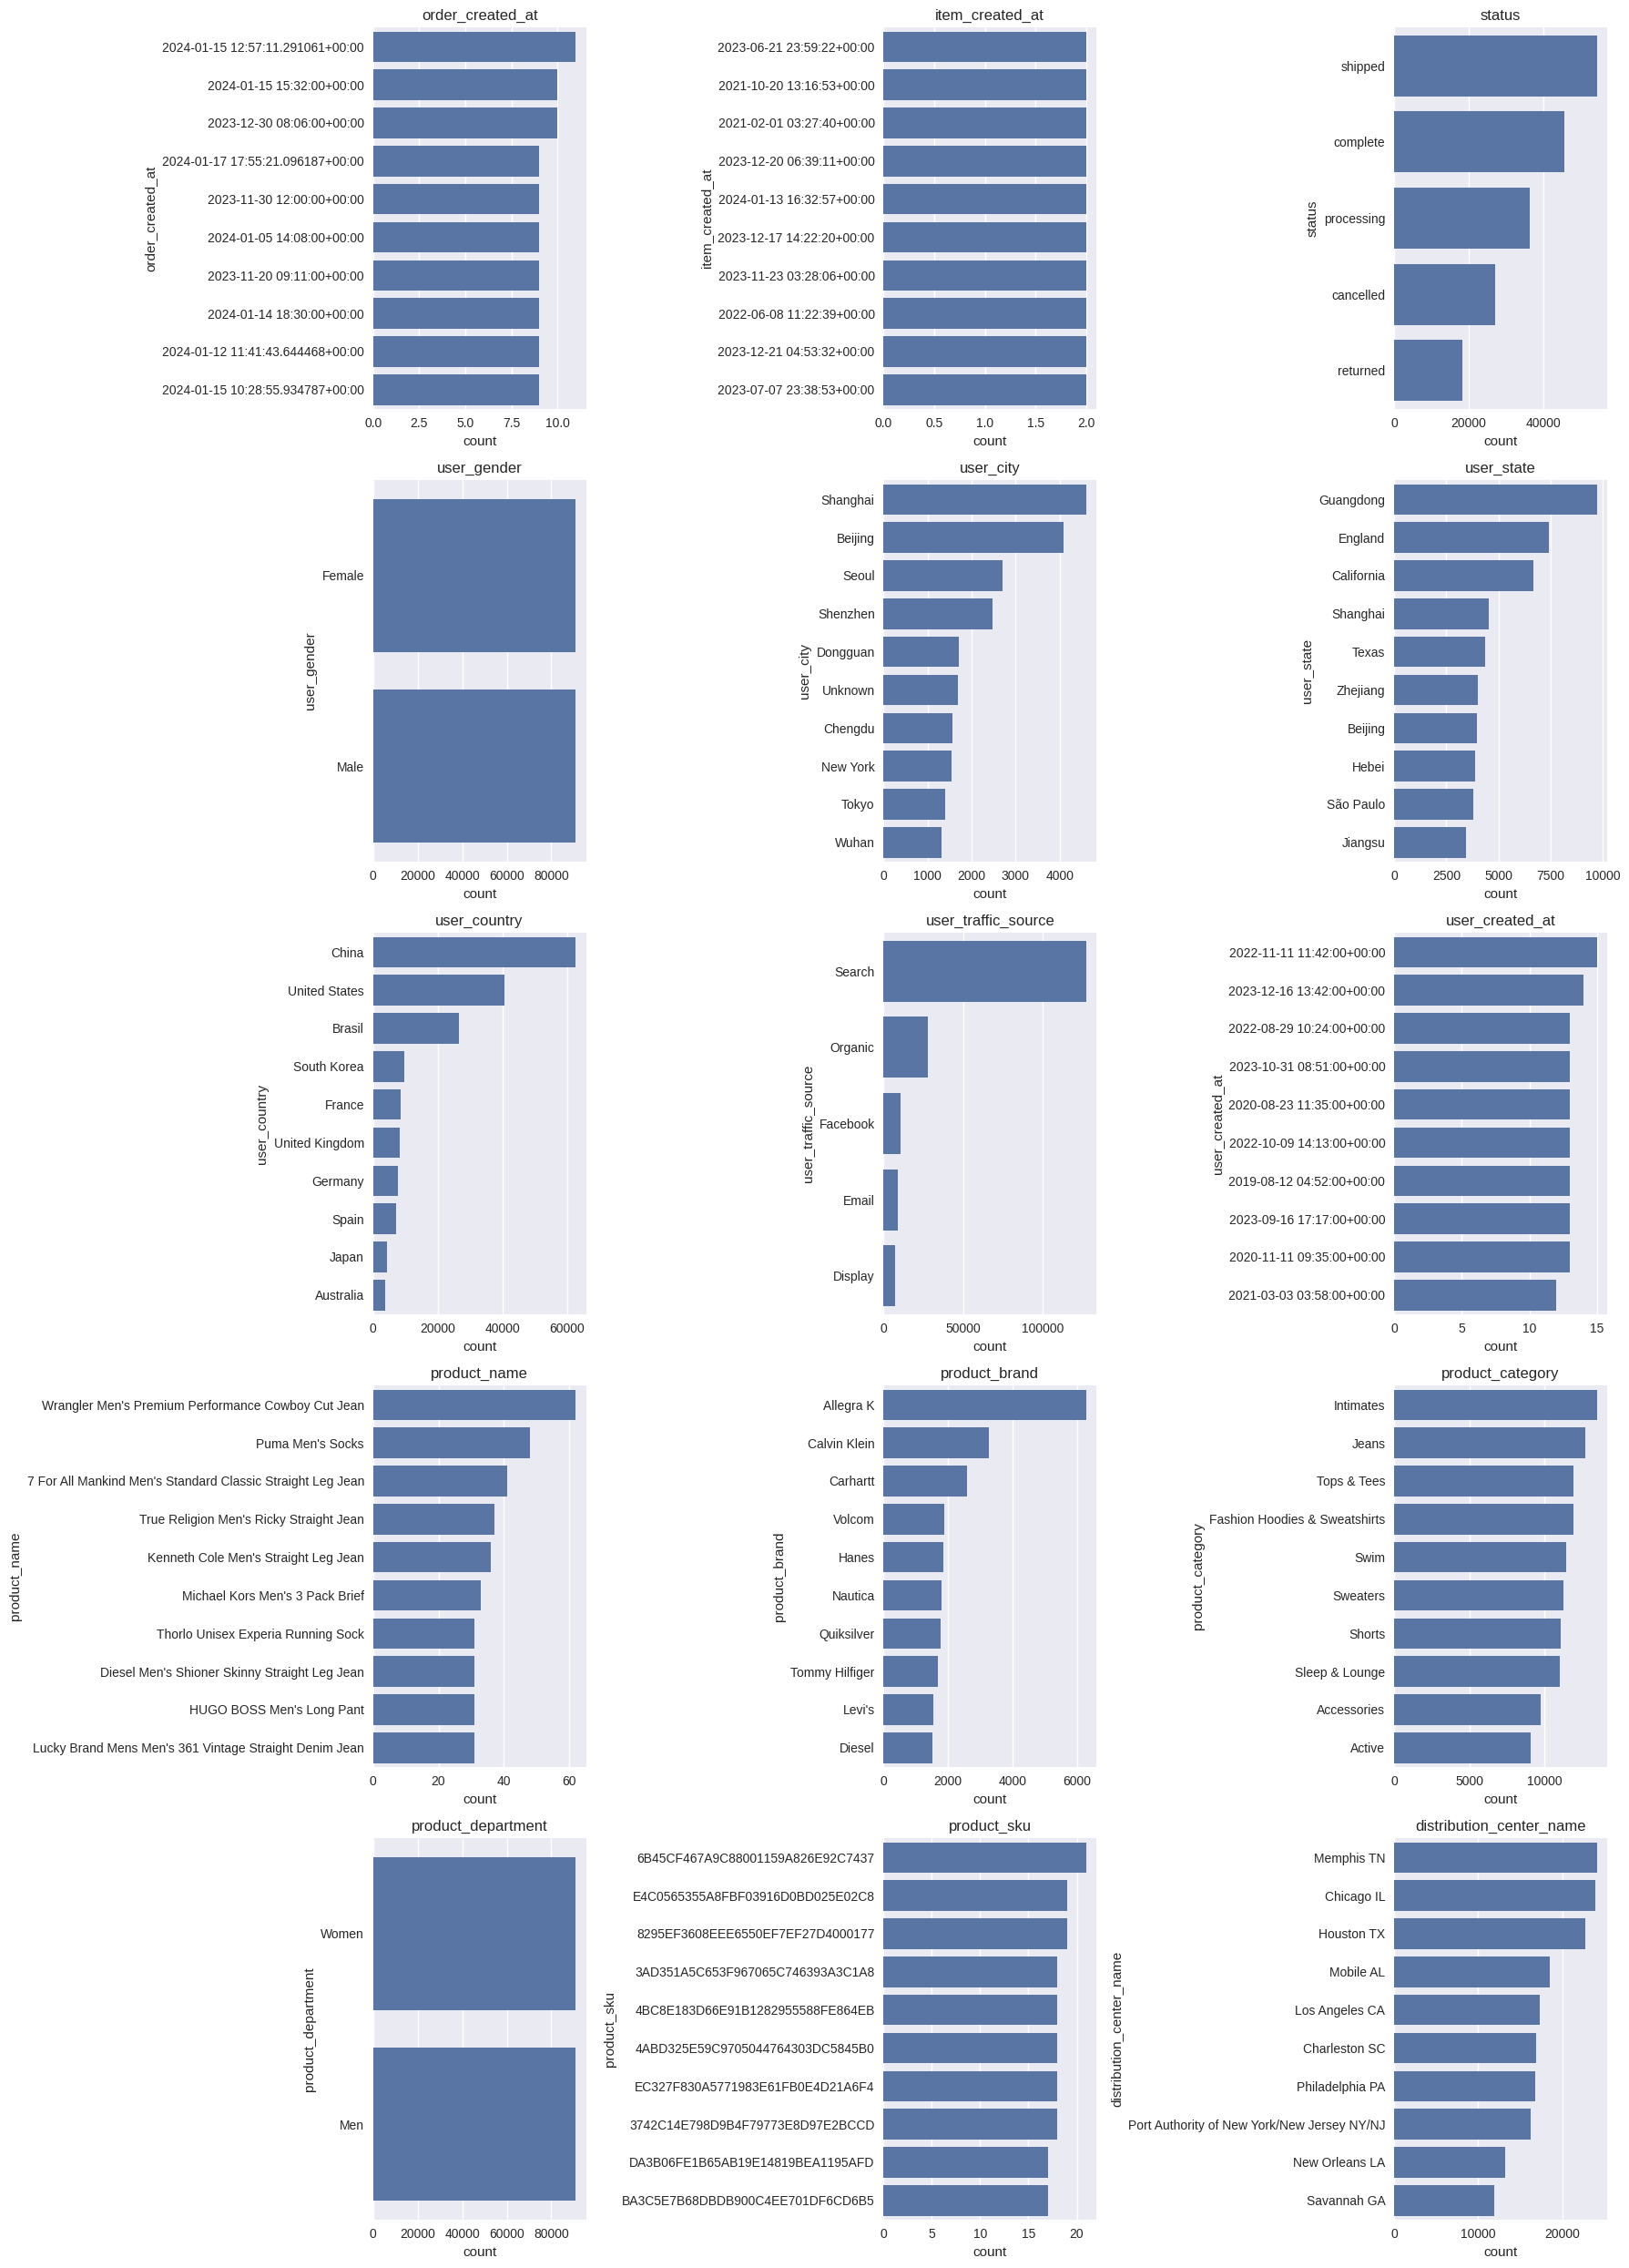

In [ ]:
# for categorical features
n_cols = 3
n_rows = math.ceil(len(categoricals.columns) / n_cols)

plt.figure(figsize=(18, 5 * n_rows))

for i, col in enumerate(categoricals.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(
        y=col,
        data=df,
        order=df[col].value_counts().index[:10]  # top 10 categories
    )
    plt.title(col)

plt.tight_layout()
plt.show()

#### Interpretasi


---



**1. Time-related Categorical (Timestamp as Category Preview): (order_created_at, item_created_at, item_shipped_at, item_delivered_at, item_returned_at, user_created_at)**

* Distribusi menunjukkan aktivitas transaksi tersebar di beberapa tanggal, dengan konsentrasi pada periode tertentu.

* Tidak terlihat anomali seperti lonjakan ekstrem pada satu timestamp tunggal yang mengindikasikan duplikasi massal.

* Kesimpulan: timestamp valid dan konsisten; pada tahap lanjutan lebih tepat dianalisis sebagai time series, bukan kategorikal murni.

**2. Order & Fulfillment Status (status)**

* Status shipped dan complete mendominasi, menunjukkan alur pemenuhan pesanan berjalan normal.

* Status processing, cancelled, dan returned jumlahnya jauh lebih kecil.

* Kesimpulan: distribusi status logis untuk e-commerce; returned cocok dianalisis lebih lanjut sebagai minority class.

**3. User Demographics (user_gender)**

* Distribusi gender relatif seimbang antara Male dan Female.

* Tidak terdapat kategori anomali (misalnya nilai kosong atau kategori tidak dikenal).

* Kesimpulan: data gender sehat dan siap digunakan untuk segmentasi.

**4. User Geography (user_city, user_state, user_country)**

* Aktivitas pengguna terkonsentrasi di China dan United States, dengan kota-kota besar seperti Shanghai dan Beijing mendominasi.

* Negara lain muncul dalam proporsi lebih kecil, mencerminkan market global dengan core region utama.

* Adanya kategori Unknown pada city menunjukkan missing value terselubung (sudah terdeteksi sebelumnya).

* Kesimpulan: data geografis informatif untuk regional analysis dan market segmentation.

**5. User Acquisition Channel (user_traffic_source)**

* Search dan Organic menjadi sumber traffic terbesar.

* Channel seperti Email dan Display berkontribusi kecil.

* Kesimpulan: akuisisi pengguna didominasi channel intent-based, relevan untuk analisis marketing ROI.

**6. Product Attributes (product_name, product_brand, product_category, product_department, product_sku)**

* Product brand didominasi oleh beberapa merek besar (misalnya Allegra K, Calvin Klein), menunjukkan pola long tail.

* Product category relatif merata, dengan kategori apparel seperti Intimates, Jeans, dan Tops & Tees menonjol.

* Product department terbagi jelas antara Men dan Women dengan distribusi seimbang.

* Product SKU sangat granular dan unik, sesuai fungsinya sebagai identifier teknis.

* Kesimpulan: struktur produk konsisten dan siap untuk aggregation-based analysis (category, brand, department).

**7. Distribution Center (distribution_center_name)**

* Terdapat 10 distribution center, dengan volume tertinggi berasal dari Memphis, TN, diikuti Chicago, Houston, dan Mobile.

* Distribusi relatif seimbang, tidak terpusat pada satu DC saja.

* Kesimpulan: jaringan logistik terdistribusi dengan baik; variabel ini sangat relevan untuk analisis supply chain dan fulfillment performance.

# E. Business-Oriented Analysis

In [ ]:
df["order_created_at"] = pd.to_datetime(df["order_created_at"], errors="coerce")

if "is_returned" not in df.columns and "status" in df.columns:
    df["is_returned"] = (df["status"].astype(str).str.lower() == "returned").astype(int)

df["order_month"] = df["order_created_at"].dt.to_period("M").dt.to_timestamp()

/tmp/ipython-input-473123073.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["order_month"] = df["order_created_at"].dt.to_period("M").dt.to_timestamp()


## 1. Revenue Trend Analysis

### Revenue by Month

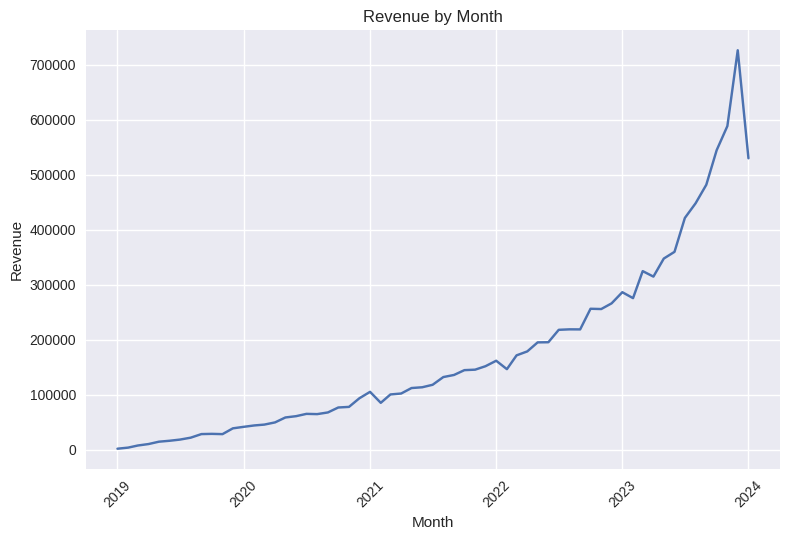

In [ ]:
rev_month = (
    df.groupby("order_month", as_index=False)
      .agg(revenue=("revenue", "sum"),
           orders=("order_id", "nunique"),
           users=("user_id", "nunique"))
      .sort_values("order_month")
)

plt.figure()
plt.plot(rev_month["order_month"], rev_month["revenue"])
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Interpretasi:


---
Revenue bulanan menunjukkan tren pertumbuhan yang kuat dan berkelanjutan dari 2019 hingga akhir 2023, dengan akselerasi signifikan sejak 2022 yang menandakan bisnis memasuki fase scaling. Kenaikan revenue yang semakin curam mengindikasikan peningkatan volume transaksi, nilai order, atau efektivitas strategi akuisisi dan retensi pelanggan. Puncak revenue terjadi di akhir 2023, diikuti sedikit penurunan pada bulan terakhir yang kemungkinan besar dipengaruhi oleh faktor musiman, normalisasi pasca-peak, atau data bulan yang belum lengkap. Secara keseluruhan, pola ini mencerminkan performa bisnis yang sehat dan bertumbuh, dengan fokus lanjutan yang relevan pada analisis seasonality, driver revenue, dan optimalisasi strategi pertumbuhan.

Highlight utama:

* Tren revenue meningkat konsisten (2019–2023)

* Akselerasi pertumbuhan kuat sejak 2022

* Peak revenue di akhir 2023, diikuti koreksi ringan

* Indikasi bisnis berada pada fase growth & scale


### Trend & Seasonality

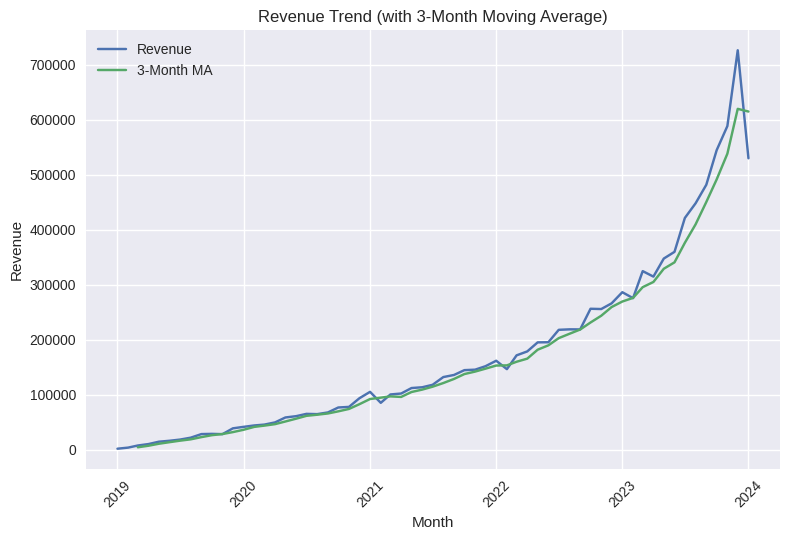

In [ ]:
rev_month["revenue_ma3"] = rev_month["revenue"].rolling(3).mean()
rev_month["mom_growth_pct"] = rev_month["revenue"].pct_change() * 100

plt.figure()
plt.plot(rev_month["order_month"], rev_month["revenue"], label="Revenue")
plt.plot(rev_month["order_month"], rev_month["revenue_ma3"], label="3-Month MA")
plt.title("Revenue Trend (with 3-Month Moving Average)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Interpretasi


---

Analisis Revenue Trend dengan 3-Month Moving Average (MA) menegaskan bahwa pertumbuhan revenue bersifat struktural dan berkelanjutan, bukan sekadar fluktuasi jangka pendek. Garis moving average yang terus meningkat dan mengikuti pola revenue aktual menunjukkan tren naik yang stabil, sekaligus meredam volatilitas bulanan. Perbedaan yang semakin lebar antara revenue aktual dan MA pada periode akhir 2023 mengindikasikan adanya lonjakan penjualan jangka pendek (misalnya kampanye promosi atau seasonal peak), sementara MA yang tetap menanjak menegaskan bahwa performa dasar bisnis tetap kuat meskipun terjadi koreksi ringan di bulan terakhir.

Highlight utama:

* 3-Month MA mengonfirmasi tren pertumbuhan jangka menengah yang konsisten

* Volatilitas bulanan relatif terkendali setelah dihaluskan oleh MA

* Lonjakan akhir 2023 terlihat sebagai spike sementara di atas tren dasar

* Koreksi di bulan terakhir tidak mengubah arah tren naik secara keseluruhan

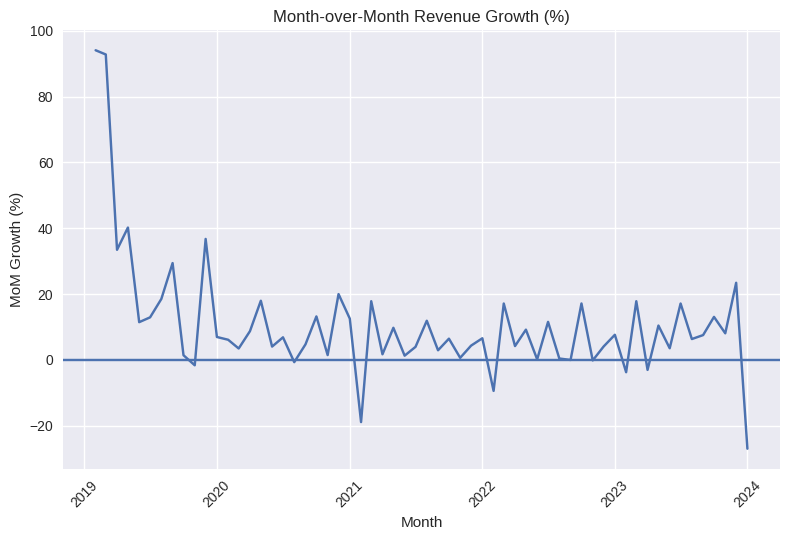

In [ ]:
plt.figure()
plt.plot(rev_month["order_month"], rev_month["mom_growth_pct"])
plt.title("Month-over-Month Revenue Growth (%)")
plt.xlabel("Month")
plt.ylabel("MoM Growth (%)")
plt.axhline(0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Peak & Low Periods

In [ ]:
top_n = 5
peak_months = rev_month.nlargest(top_n, "revenue")[["order_month", "revenue"]]
low_months  = rev_month.nsmallest(top_n, "revenue")[["order_month", "revenue"]]


In [ ]:
print("Top Revenue Months:")
display(peak_months)

Top Revenue Months:


,order_month,revenue
59,2023-12-01,726339.010560
58,2023-11-01,588526.200546
57,2023-10-01,544667.370469
60,2024-01-01,529992.090540
56,2023-09-01,481816.500582


In [ ]:
print("\nLowest Revenue Months:")
display(low_months)


Lowest Revenue Months:


,order_month,revenue
0,2019-01-01,2125.080007
1,2019-02-01,4125.010007
2,2019-03-01,7954.160018
3,2019-04-01,10614.860044
4,2019-05-01,14883.059994


##### Interpretasi:


---

Analisis Month-over-Month (MoM) Revenue Growth menunjukkan bahwa meskipun arah jangka panjang revenue bersifat meningkat, pertumbuhan bulanan bersifat fluktuatif dan tidak stabil, terutama pada fase awal dan periode tertentu. Di awal observasi terlihat lonjakan MoM yang sangat tinggi, yang umumnya mencerminkan base effect akibat revenue awal yang masih rendah. Setelah fase tersebut, pertumbuhan MoM cenderung berada pada kisaran positif moderat dengan beberapa bulan mengalami kontraksi, menandakan adanya volatilitas musiman, siklus promosi, atau faktor operasional. Penurunan tajam di periode akhir kemungkinan disebabkan oleh koreksi setelah puncak penjualan, bukan indikasi pelemahan tren jangka panjang.

Highlight utama:

* Lonjakan MoM ekstrem di awal periode dipengaruhi base effect

* Mayoritas bulan menunjukkan pertumbuhan positif namun tidak konsisten

* Terdapat beberapa bulan dengan kontraksi yang bersifat sementara

* Penurunan MoM di akhir periode lebih mencerminkan koreksi pasca-peak daripada penurunan struktural

## 2. Return Rate Analysis

### Overall Return Rate

In [ ]:
overall_return_rate = df["is_returned"].mean() * 100
print(f"Overall Return Rate: {overall_return_rate:.2f}%")

Overall Return Rate: 9.78%


### Return Rate by

#### Month

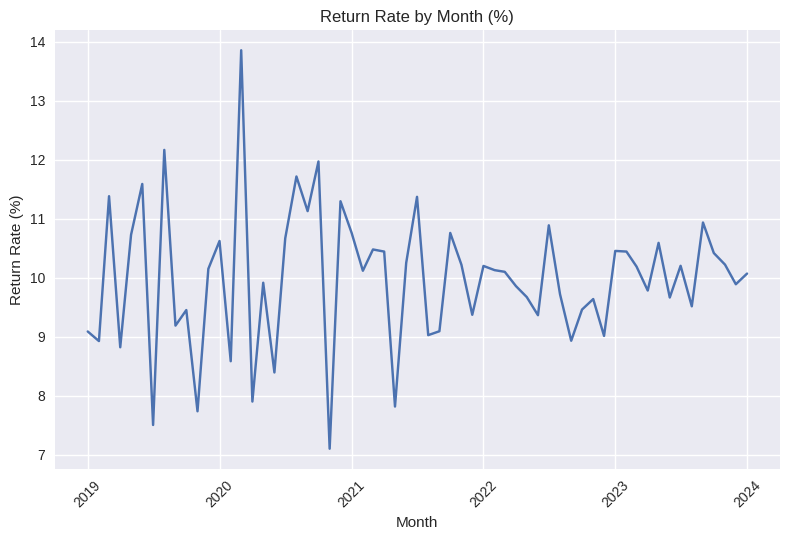

In [ ]:
ret_month = (
    df.groupby("order_month", as_index=False)
      .agg(return_rate=("is_returned", "mean"),
           returned_items=("is_returned", "sum"),
           total_items=("is_returned", "size"))
      .sort_values("order_month")
)
ret_month["return_rate_pct"] = ret_month["return_rate"] * 100

plt.figure()
plt.plot(ret_month["order_month"], ret_month["return_rate_pct"])
plt.title("Return Rate by Month (%)")
plt.xlabel("Month")
plt.ylabel("Return Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Interpretasi:


---

Grafik menunjukkan bahwa return rate bulanan berada pada kisaran yang relatif stabil, umumnya antara sekitar 8% hingga 12% sepanjang periode 2019–2024, dengan fluktuasi jangka pendek namun tanpa tren kenaikan atau penurunan struktural yang signifikan. Pada fase awal (2019–2020) terlihat volatilitas yang lebih tinggi, kemungkinan dipengaruhi oleh skala transaksi yang masih berkembang atau ketidakstabilan operasional awal. Memasuki 2021 hingga 2024, return rate cenderung lebih terkendali dan konsisten di sekitar ~10%, mengindikasikan proses pemenuhan pesanan, kualitas produk, dan ekspektasi pelanggan yang semakin stabil seiring pertumbuhan bisnis.

**Highlight utama:**

* Return rate stabil di kisaran ±10%, menunjukkan tingkat pengembalian yang masih wajar untuk e-commerce apparel.

* Volatilitas lebih tinggi pada periode awal (2019–2020), lalu menurun setelah 2021, menandakan maturitas operasional.

* Tidak terlihat tren peningkatan return rate meskipun revenue meningkat signifikan, yang merupakan sinyal positif dari sisi kualitas dan customer experience.

#### Category

In [ ]:
ret_by_cat = (
    df.groupby("product_category", as_index=False)
      .agg(return_rate=("is_returned", "mean"),
           total_items=("is_returned", "size"))
)
ret_by_cat["return_rate_pct"] = ret_by_cat["return_rate"] * 100

# tampilkan top kategori dengan return rate tertinggi (min volume filter opsional)
min_items = 200
ret_by_cat_f = ret_by_cat[ret_by_cat["total_items"] >= min_items].sort_values("return_rate_pct", ascending=False)

print("Return Rate by Category (filtered):")
display(ret_by_cat_f.head(10))

Return Rate by Category (filtered):


,product_category,return_rate,total_items,return_rate_pct
8,Jumpsuits & Rompers,0.110278,934,11.027837
20,Suits,0.106445,1024,10.644531
12,Pants,0.103166,7328,10.316594
1,Active,0.102245,9086,10.224521
14,Plus,0.101550,4323,10.154985
21,Suits & Sport Coats,0.101474,5223,10.147425
15,Shorts,0.100924,11038,10.092408
10,Maternity,0.100484,5165,10.048403
6,Intimates,0.099599,13474,9.959923
25,Underwear,0.099508,7527,9.950844


##### Interpretasi:


---

Tabel menunjukkan bahwa return rate antar kategori produk relatif homogen dan terkonsentrasi di kisaran ±10%, menandakan bahwa pengembalian barang merupakan karakteristik umum lintas kategori, bukan anomali pada satu segmen tertentu. Kategori seperti Jumpsuits & Rompers, Suits, dan Pants berada di sisi atas return rate (≈10,3–11,0%), yang umumnya berkaitan dengan isu fit, ukuran, atau preferensi gaya yang lebih subjektif. Sementara itu, kategori Intimates dan Underwear memiliki return rate sedikit lebih rendah (10%), meskipun volume transaksi cukup besar, mengindikasikan keputusan pembelian yang lebih pasti atau kebijakan retur yang lebih ketat. Secara keseluruhan, perbedaan return rate lebih didorong oleh karakteristik produk daripada kualitas operasional.

**Highlight utama:**

* Return rate antar kategori relatif konsisten di sekitar 10%, tidak ada kategori ekstrem.

* Kategori fashion berbasis fit kompleks (Jumpsuits, Suits, Pants) cenderung memiliki return rate lebih tinggi.

* Intimates & Underwear menunjukkan return rate lebih rendah meski volume tinggi → segmen relatif stabil.

* Fokus perbaikan sebaiknya pada size guidance, product description, dan visual fitting untuk kategori dengan return rate tertinggi.

#### Brand (top brand)

In [ ]:
top_k = 10
top_brands = (
    df.groupby("product_brand", as_index=False)
      .agg(total_items=("order_item_id", "count"),
           revenue=("revenue", "sum"))
      .sort_values("total_items", ascending=False)
      .head(top_k)["product_brand"]
)

ret_by_brand = (
    df[df["product_brand"].isin(top_brands)]
    .groupby("product_brand", as_index=False)
    .agg(return_rate=("is_returned", "mean"),
         total_items=("order_item_id", "count"),
         revenue=("revenue", "sum"))
)

ret_by_brand["return_rate_pct"] = ret_by_brand["return_rate"] * 100
ret_by_brand = ret_by_brand.sort_values("return_rate_pct", ascending=False)

print("Return Rate by Top Brands:")
display(ret_by_brand)

Return Rate by Top Brands:


,product_brand,return_rate,total_items,revenue,return_rate_pct
6,Nautica,0.104528,1789,74710.610244,10.452767
9,Volcom,0.103688,1871,106950.029760,10.368787
1,Calvin Klein,0.101524,3280,208658.220517,10.152439
4,Hanes,0.100108,1858,36878.040007,10.010764
0,Allegra K,0.098379,6292,90115.100008,9.837889
5,Levi's,0.094463,1535,79236.681227,9.446254
3,Diesel,0.093894,1523,199889.419819,9.389363
7,Quiksilver,0.089938,1779,105024.680113,8.993817
8,Tommy Hilfiger,0.088570,1671,126127.230120,8.856972
2,Carhartt,0.081123,2601,183997.288993,8.112265


##### Interpretasi:


---

Return rate antar brand berada pada rentang yang relatif sempit (≈8,1%–10,5%), menunjukkan bahwa variasi pengembalian lebih dipengaruhi oleh karakteristik produk dan positioning brand daripada masalah operasional yang spesifik. Brand seperti Nautica, Volcom, dan Calvin Klein berada di sisi atas return rate (≈10–10,5%), yang kemungkinan berkaitan dengan produk fashion dengan ekspektasi fit dan gaya yang tinggi. Sebaliknya, Carhartt, Tommy Hilfiger, dan Quiksilver menunjukkan return rate terendah (9%), meskipun beberapa di antaranya menghasilkan revenue yang besar, menandakan kombinasi yang lebih sehat antara penjualan dan kepuasan pelanggan. Tidak terlihat korelasi langsung antara revenue tinggi dan return rate tinggi, sehingga return tidak semata-mata didorong oleh volume penjualan.

Highlight utama:

* Return rate brand terkonsentrasi di sekitar 9–10%, tidak ada outlier ekstrem.

* Nautica & Volcom memiliki return rate tertinggi → perlu perhatian pada sizing/expectation management.

* Carhartt memiliki return rate terendah (~8,1%) dengan revenue besar → benchmark kualitas & konsistensi produk.

* Revenue tinggi tidak selalu berarti return tinggi, membuka peluang optimasi tanpa mengorbankan penjualan.

* Strategi rekomendasi: lakukan brand-level deep dive pada kategori produk utama untuk brand dengan return rate tertinggi.

#### Customer Segment vs Revenue/Return

RFM Base Table

In [ ]:
snapshot_date = df["order_created_at"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("user_id", as_index=False)
      .agg(
          recency=("order_created_at", lambda x: (snapshot_date - x.max()).days),
          frequency=("order_id", "nunique"),
          monetary=("revenue", "sum"),
          return_items=("is_returned", "sum"),
          total_items=("is_returned", "size")
      )
)
rfm["return_rate"] = rfm["return_items"] / rfm["total_items"]

RFM Scoring

In [ ]:
rfm["R"] = pd.qcut(rfm["recency"], 4, labels=[4,3,2,1], duplicates='drop').fillna(1).astype(int)
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1,2,3,4], duplicates='drop').fillna(1).astype(int)
rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"), 4, labels=[1,2,3,4], duplicates='drop').fillna(1).astype(int)

rfm["RFM_Score"] = rfm["R"] + rfm["F"] + rfm["M"]

def rfm_segment(score):
    if score >= 10: return "High Value"
    if score >= 7:  return "Mid Value"
    return "Low Value"

rfm["segment"] = rfm["RFM_Score"].apply(rfm_segment)

Segment vs Revenue/Return

In [ ]:
seg_summary = (
    rfm.groupby("segment", as_index=False)
       .agg(
           customers=("user_id", "count"),
           avg_revenue_per_user=("monetary", "mean"),
           total_revenue=("monetary", "sum"),
           avg_return_rate=("return_rate", "mean"),
           avg_frequency=("frequency", "mean"),
           avg_recency=("recency", "mean")
       )
       .sort_values("total_revenue", ascending=False)
)

print("Customer Segment vs Revenue/Return:")
display(seg_summary)

Customer Segment vs Revenue/Return:


,segment,customers,avg_revenue_per_user,total_revenue,avg_return_rate,avg_frequency,avg_recency
0,High Value,18311,267.287920,4.894309e+06,0.099423,2.621921,126.086123
2,Mid Value,31070,136.354971,4.236549e+06,0.099858,1.474702,324.164493
1,Low Value,30663,55.319468,1.696261e+06,0.095278,1.023938,621.729544


#### Interpretasi


---

Segmentasi pelanggan menunjukkan perbedaan yang jelas dalam kontribusi pendapatan dan perilaku belanja. High Value customers meskipun jumlahnya paling sedikit, memberikan total revenue tertinggi dengan average revenue per user (ARPU) yang jauh lebih besar dan frekuensi pembelian yang lebih tinggi, menandakan loyalitas dan nilai jangka panjang yang kuat. Mid Value customers merupakan segmen terbesar secara jumlah dan berperan sebagai penopang stabil pendapatan dengan pola belanja moderat, sementara Low Value customers memiliki kontribusi revenue paling kecil, frekuensi rendah, serta recency yang tinggi (lebih lama tidak bertransaksi), sehingga berisiko churn. Menariknya, average return rate relatif seragam (~9,5–10%) di semua segmen, menunjukkan bahwa tingkat pengembalian tidak terlalu dipengaruhi oleh nilai pelanggan, melainkan lebih ke faktor produk atau ekspektasi.

Highlight utama (business insight):

**High Value:**

* ARPU & frekuensi tertinggi → fokus utama untuk retention & loyalty program.

* Kontributor revenue terbesar meski jumlah pelanggan lebih kecil.

**Mid Value:**

* Basis pelanggan terbesar → peluang upselling untuk naik ke High Value.

* Revenue total hampir setara dengan High Value.

**Low Value:**

* Recency paling tinggi → indikasi pelanggan pasif / churn risk.

* Cocok untuk reactivation campaign berbiaya rendah.

Return rate konsisten antar segmen → isu return lebih relevan dianalisis di level produk, kategori, atau brand, bukan customer value.

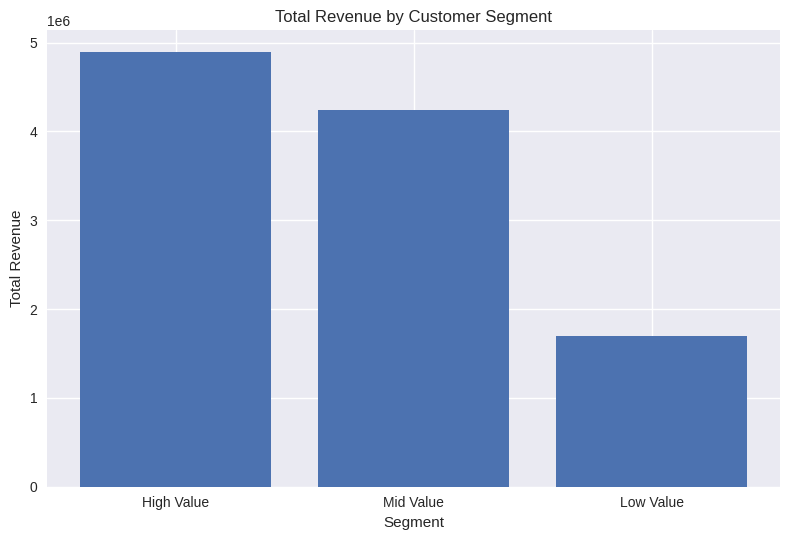

In [ ]:
# Plot: total revenue by segment
plt.figure()
plt.bar(seg_summary["segment"], seg_summary["total_revenue"])
plt.title("Total Revenue by Customer Segment")
plt.xlabel("Segment")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

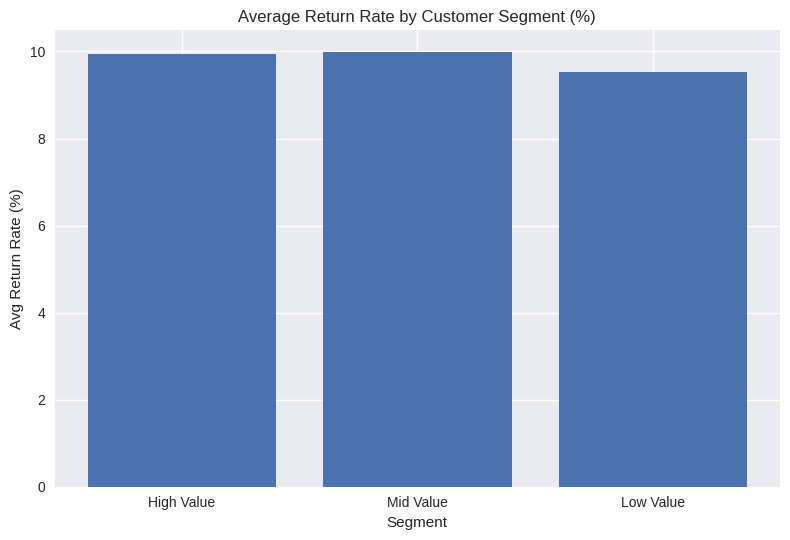

In [ ]:
# Plot: avg return rate by segment (%)
plt.figure()
plt.bar(seg_summary["segment"], seg_summary["avg_return_rate"] * 100)
plt.title("Average Return Rate by Customer Segment (%)")
plt.xlabel("Segment")
plt.ylabel("Avg Return Rate (%)")
plt.tight_layout()
plt.show()

#### Interpretasi


---

Grafik menunjukkan bahwa segmen High Value merupakan kontributor revenue terbesar, diikuti oleh Mid Value, sementara Low Value menyumbang porsi revenue paling kecil. Hal ini menegaskan bahwa sebagian besar pendapatan perusahaan didorong oleh pelanggan dengan nilai tinggi yang memiliki kombinasi frekuensi transaksi lebih sering dan nilai belanja lebih besar. Meskipun jumlah pelanggan Mid Value dan Low Value relatif besar, kontribusi revenue mereka tidak sebanding dengan High Value, yang mengindikasikan adanya peluang strategis untuk meningkatkan monetisasi melalui up-selling, cross-selling, atau migrasi pelanggan dari segmen Mid dan Low ke High Value.

Highlight utama (business insights):

* High Value customers adalah tulang punggung revenue → prioritas utama untuk retention dan loyalty program.

* Mid Value customers memiliki potensi pertumbuhan terbesar → target ideal untuk strategi upgrade segment.

* Low Value customers berkontribusi kecil terhadap revenue → perlu pendekatan cost-efficient atau kampanye reaktivasi selektif.

* Fokus bisnis sebaiknya bukan hanya akuisisi, tetapi menggeser distribusi revenue ke segmen bernilai tinggi melalui strategi berbasis RFM.

#### RFM Summary

In [ ]:
rfm_summary = (
    rfm.assign(rfm_code=lambda d: d["R"].astype(str) + d["F"].astype(str) + d["M"].astype(str))
       .groupby("rfm_code", as_index=False)
       .agg(customers=("user_id","count"),
            total_revenue=("monetary","sum"),
            avg_return_rate=("return_rate","mean"),
            avg_frequency=("frequency","mean"),
            avg_recency=("recency","mean"))
       .sort_values("total_revenue", ascending=False)
)

print("Top RFM Codes by Revenue:")
display(rfm_summary.head(10))

Top RFM Codes by Revenue:


,rfm_code,customers,total_revenue,avg_return_rate,avg_frequency,avg_recency
63,444,4067,1.408498e+06,0.099057,3.180477,39.259897
47,344,3184,1.117375e+06,0.103552,3.080716,168.783291
31,244,2221,7.557546e+05,0.098091,2.976587,398.911751
15,144,1437,4.896414e+05,0.083811,2.763396,832.275174
59,434,1267,3.947814e+05,0.109310,1.846882,41.153118
27,234,1211,3.633602e+05,0.099377,1.767135,408.616846
43,334,1189,3.530466e+05,0.093276,1.777124,170.918419
11,134,1010,3.057513e+05,0.079675,1.644554,899.581599
62,443,1968,2.670351e+05,0.095196,2.616870,40.419207
46,343,1624,2.203894e+05,0.095609,2.537562,169.833744


Hasil analisis menunjukkan bahwa RFM code 444 merupakan segmen pelanggan paling bernilai, dengan jumlah pelanggan terbesar di antara top RFM dan total revenue tertinggi, didukung oleh frekuensi transaksi paling tinggi serta recency yang sangat rendah, yang menandakan pelanggan aktif dan loyal. Segmen dengan recency rendah (≈ 39–41 hari) seperti 444, 434, dan 443 secara konsisten menghasilkan revenue tinggi, menegaskan bahwa kedekatan waktu transaksi terakhir (recency) adalah pendorong utama pendapatan. Sebaliknya, RFM dengan recency sangat tinggi (≥ 800 hari) seperti 144 dan 134 masih menyumbang revenue, namun ini lebih bersifat historis dan berisiko menurun jika tidak ada intervensi. Return rate di seluruh top RFM relatif stabil di kisaran 8–11%, sehingga perbedaan kinerja revenue lebih dipengaruhi oleh frekuensi dan recency, bukan oleh tingkat retur.

**Highlight utama (business insights):**

* RFM 444 (Champions)

  * Revenue tertinggi, frekuensi paling tinggi, recency terendah

  * Target utama untuk loyalty, eksklusif promo, dan retention

* RFM dengan recency rendah (444, 434, 443)

  * Konsisten menghasilkan revenue besar

  * Cocok untuk cross-sell dan upsell

* RFM dengan recency tinggi (144, 134)

  * Kontribusi revenue masih ada, namun bersifat legacy

  * Kandidat utama untuk reactivation campaign

* Return rate relatif seragam

  * Optimalisasi revenue lebih efektif difokuskan pada peningkatan frequency & recency, bukan pengurangan return di level segmen RFM

# G. Insight Summary

Secara keseluruhan, analisis menunjukkan bahwa bisnis mengalami pertumbuhan revenue yang kuat dan konsisten dari waktu ke waktu, dengan percepatan signifikan sejak 2022. Meskipun terdapat fluktuasi month-over-month, tren jangka panjang tetap positif dan didukung oleh peningkatan volume transaksi serta kontribusi pelanggan bernilai tinggi.

Dari sisi kualitas operasional, return rate relatif stabil di kisaran ±9–11% sepanjang periode observasi. Hal ini mengindikasikan bahwa pertumbuhan revenue tidak diiringi peningkatan risiko pengembalian, sehingga ekspansi bisnis masih berada dalam batas operasional yang sehat. Variasi return rate lebih dipengaruhi oleh karakteristik produk dan kategori, bukan oleh waktu atau lonjakan volume transaksi.

Analisis kategori dan brand mengungkapkan bahwa beberapa kategori seperti Jumpsuits & Rompers, Suits, dan Pants memiliki return rate di atas rata-rata, sedangkan brand tertentu menunjukkan tingkat return yang lebih rendah meskipun berkontribusi besar terhadap revenue. Temuan ini membuka peluang untuk perbaikan kualitas produk, sizing, atau deskripsi produk pada kategori berisiko tinggi, serta benchmarking praktik terbaik dari brand dengan return rate rendah.

Dari perspektif pelanggan, segmen High Value meskipun jumlahnya lebih kecil, memberikan kontribusi revenue terbesar dengan frekuensi transaksi yang tinggi dan recency yang lebih baik. Menariknya, return rate antar segmen relatif serupa, yang menunjukkan bahwa perilaku pengembalian lebih dipengaruhi oleh produk daripada tipe pelanggan. RFM analysis memperkuat temuan ini dengan mengidentifikasi kelompok pelanggan bernilai tinggi yang sangat potensial untuk program retensi dan loyalty.

**Highlight Utama:**

* Revenue tumbuh kuat dan berkelanjutan, terutama sejak 2022

* Return rate stabil meski volume transaksi meningkat

* Risiko return lebih dominan di level produk/kategori, bukan customer

* High Value customer adalah revenue backbone, bukan risk driver

* RFM segmentation efektif untuk strategi retensi & upselling

Secara keseluruhan, bisnis berada dalam fase growth yang sehat, dengan peluang peningkatan profitabilitas melalui optimasi produk dan strategi retensi pelanggan bernilai tinggi

# Export csv for Power BI

In [ ]:
# ---------- STANDARDIZE NUMERIC TYPES FOR BI ----------

# Revenue-related
rev_month["revenue"] = rev_month["revenue"].astype(float).round(2)

# MoM Growth
rev_month["mom_growth_pct"] = rev_month["mom_growth_pct"].astype(float).round(2)

# Return rate by month
ret_month["return_rate"] = ret_month["return_rate"].astype(float).round(4)
ret_month["return_rate_pct"] = ret_month["return_rate_pct"].astype(float).round(2)

# Return rate by category
ret_by_cat_f["return_rate"] = ret_by_cat_f["return_rate"].astype(float).round(4)
ret_by_cat_f["return_rate_pct"] = ret_by_cat_f["return_rate_pct"].astype(float).round(2)

# Return rate by brand
ret_by_brand["return_rate"] = ret_by_brand["return_rate"].astype(float).round(4)
ret_by_brand["return_rate_pct"] = ret_by_brand["return_rate_pct"].astype(float).round(2)
ret_by_brand["revenue"] = ret_by_brand["revenue"].astype(float).round(2)

# Customer segment summary
seg_summary["avg_revenue_per_user"] = seg_summary["avg_revenue_per_user"].astype(float).round(2)
seg_summary["total_revenue"] = seg_summary["total_revenue"].astype(float).round(2)
seg_summary["avg_return_rate"] = seg_summary["avg_return_rate"].astype(float).round(4)
seg_summary["avg_frequency"] = seg_summary["avg_frequency"].astype(float).round(2)
seg_summary["avg_recency"] = seg_summary["avg_recency"].astype(float).round(1)

# RFM summary
rfm_summary["total_revenue"] = rfm_summary["total_revenue"].astype(float).round(2)
rfm_summary["avg_return_rate"] = rfm_summary["avg_return_rate"].astype(float).round(4)
rfm_summary["avg_frequency"] = rfm_summary["avg_frequency"].astype(float).round(2)
rfm_summary["avg_recency"] = rfm_summary["avg_recency"].astype(float).round(1)

In [ ]:
# ---------- EXPORT BI-READY CSV ----------

rev_month.to_csv(
    "revenue_by_month.csv",
    index=False,
    float_format="%.2f"
)

rev_month.to_csv(
    "mom_revenue_growth.csv", # Mom growth is part of rev_month
    index=False,
    float_format="%.2f"
)

ret_month.to_csv(
    "return_rate_by_month.csv",
    index=False,
    float_format="%.4f"
)

ret_by_cat_f.to_csv(
    "return_rate_by_category.csv",
    index=False,
    float_format="%.4f"
)

ret_by_brand.to_csv(
    "return_rate_by_brand.csv",
    index=False,
    float_format="%.4f"
)

seg_summary.to_csv(
    "customer_segment_summary.csv",
    index=False,
    float_format="%.4f"
)

rfm_summary.to_csv(
    "rfm_summary.csv",
    index=False,
    float_format="%.4f"
)